In [1]:
import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import Utils.DiaSourceTools as DSTools
from astropy.time import Time

import lsst.afw.display.ds9 as ds9

import re

from multiprocessing import Pool
from functools import partial

In [2]:
DATADIR="/datadec/cppm/jpreyes/CFHT_Complete"
directory = DATADIR+"/detect_testSN_2/"
butler = dafPersist.Butler(directory) 
filter = 'r'


In [3]:
stack_colors = {"sdssg":"green", "sdssi":"blue", "sdssr":"red", "sdssz":"magenta"}
snls_colors = {"sdssg":"darkgreen", "sdssi":"darkblue", "sdssr":"darkred", "sdssz":"purple"}

In [4]:
patches = []
patches_file=open(DATADIR+"/patches.txt", "rb")
for line in patches_file:
    line = line.replace('\n','')
    text = re.split("=| ",line)
    patches.append(text[-1])
patches_file.close()

dates = []
days_file=open(DATADIR+"/days_06.txt", "rb")

for day in days_file:
    day = day.replace('\n','')
    dates.append(day)

days_file.close()
print dates

['2006-01-02', '2006-01-07', '2006-01-08', '2006-01-31', '2006-02-03', '2006-02-05', '2006-02-06', '2006-02-25', '2006-03-04', '2006-03-05', '2006-03-07', '2006-04-22', '2006-04-23', '2006-04-26', '2006-04-28', '2006-04-30', '2006-05-04', '2006-05-20', '2006-05-24', '2006-05-27', '2006-05-28', '2006-06-02', '2006-06-04', '2006-06-06', '2006-06-20', '2006-06-23', '2006-06-24', '2006-06-25', '2006-06-29', '2006-06-30', '2006-07-03', '2006-07-19', '2006-07-20', '2006-07-23', '2006-07-27']


In [7]:

def get_light_curves_per_patch(butler, filter, dates, patch):

    multi_matches = None
    results = []
    stack_lcs = []
    for date in dates:
        t = Time(date)
        date_catalog = None
        #print date
        if butler.datasetExists("dayDiff_class_diaSrc", dataId={"filter":filter,"tract":0, "patch":patch, 'date':date}):
            date_catalog = butler.get("dayDiff_class_diaSrc", dataId={"filter":filter,"tract":0, "patch":patch, 'date':date})
            if multi_matches is None:
                multi_matches= afwTable.MultiMatch(date_catalog.schema, {'mjd':'D'}, radius=afwGeom.Angle(1./3600., afwGeom.degrees))
            multi_matches.add(date_catalog, {'mjd':int(t.mjd)})


    if multi_matches is not None:
        results = multi_matches.finish(removeAmbiguous=False)
        lcs = DSTools.get_light_curves_from_multimatch_results2(results)
        t_lcs = DSTools.threshold_light_curves(lcs, 3)
        for t_lc in t_lcs:
            stack_lcs.append(DSTools.build_lightcurve4(t_lc, "base_CircularApertureFlux_4_5_flux", filter))
            
    return patch, stack_lcs

def function(args):
    return get_light_curves_per_patch(*args)

In [9]:
res = function((butler, 'r', dates, '10,10'))



In [20]:
res[1]

[<Table length=4>
   mjd   classification zpsys      flux      ...     dec         zp   bandpass
 float64    float64      str2    float64     ...    object    float64   str5  
 ------- -------------- ----- -------------- ... ------------ ------- --------
 53081.0            4.0    ab -4.36701488495 ... 0.915069 rad    25.0    sdssr
 53083.0            4.0    ab -4.39094591141 ... 0.915069 rad    25.0    sdssr
 53094.0            4.0    ab -4.38691329956 ... 0.915069 rad    25.0    sdssr
 53109.0            4.0    ab -4.34102487564 ...  0.91507 rad    25.0    sdssr,
 <Table length=4>
   mjd   classification zpsys      flux      ...     dec         zp   bandpass
 float64    float64      str2    float64     ...    object    float64   str5  
 ------- -------------- ----- -------------- ... ------------ ------- --------
 53081.0            4.0    ab -6.87165164948 ... 0.915071 rad    25.0    sdssr
 53083.0            4.0    ab -6.88749361038 ... 0.915071 rad    25.0    sdssr
 53094.0       

In [76]:
p = Pool(200)



params = [(butler, 'r', dates, patch) for patch in patches]
params2 = [(butler, 'g', dates, patch) for patch in patches]
params3 = [(butler, 'i', dates, patch) for patch in patches]


params.extend(params2)
params.extend(params3)

#params = [(butler, 'r', dates, '20,20')]
#butler_z = dafPersist.Butler("/datadec/cppm/jpreyes/CFHT_filter_z/detect_testSN_6") 
params4 = [(butler, 'z', dates, patch) for patch in patches]

params.extend(params4)
#print params
res = p.map(function, params)
#f = Pool(25).map(get_light_curves_per_patch, ([butler], ['g'], ['0,20'], [dates]))

In [22]:
from astropy.table import Table, vstack
lcs = {}
for r in res:
    if len(r[1])>0:
        if lcs.has_key(r[0]):
            lcs[r[0]].extend(r[1])
        else:
            lcs[r[0]] = r[1]

lcs2 = lcs
lcs = lcs.values()
print len(lcs)

2


In [19]:


def build_multi_filter_lc(lcs):
    final_lc = []
 
    for lc in lcs:
        added = False
        
        for i, f_lc in enumerate(final_lc):
            s1 = {'ra':np.mean(lc["ra"]), 'dec':np.mean(lc["dec"])}
            s2 = {'ra':np.mean(f_lc["ra"]), 'dec':np.mean(f_lc["dec"])}
      
            if DSTools.source_distance(s1,s2)<1:             
                added = True
                final_lc[i] = vstack([lc, f_lc])
                  #print final_lc[i]
        if added == False:
                  final_lc.append(lc)
                  
    return final_lc
        

In [45]:
lcs = res[1]
tot_lcs = build_multi_filter_lc(lcs)

In [ ]:
p = Pool(100)
mf_lcs = p.map(build_multi_filter_lc, lcs)

In [ ]:
tot_lcs = []
for p_lc in mf_lcs:
    tot_lcs.extend(p_lc)

In [37]:
len(tot_lcs)

64

In [ ]:
def show_multi_filter_light_curve(t, colors, n_factor = None):

    t_by_filter = t.group_by("bandpass")

    indices = t_by_filter.groups.indices
    #print indices

    for i in range(0, len(indices)-1):

        data = t_by_filter[indices[i]:indices[i+1]]
        
        if n_factor is not None:
            value = n_factor[data[0]["bandpass"]]
            f = value if np.isnan(value) == False else 1
            plt.errorbar(data["mjd"], data["flux"]*f,yerr=data["flux_error"]*f, fmt='.', markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])            
        else:
            plt.errorbar(data["mjd"], data["flux"],yerr=data["flux_error"], fmt='.', markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])
    plt.legend()
    #plt.show()

04D3bf 214.437779167 52.4677916667


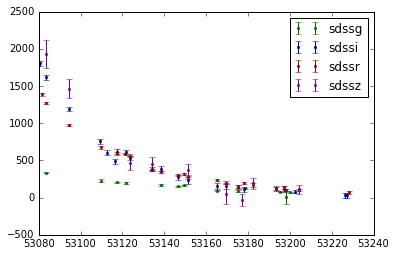

04D3co 214.458245833 52.9636111111


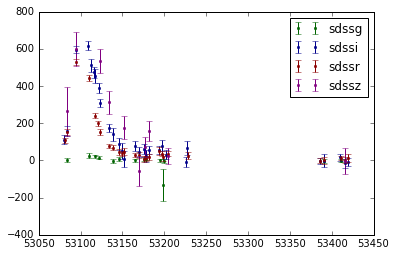

04D3cp 215.099658333 52.8209333333


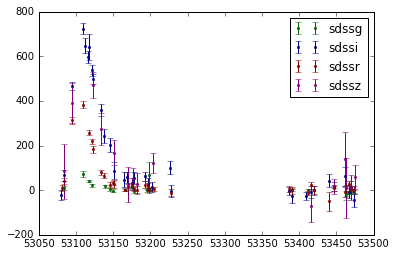

04D3cy 214.551808333 52.6583305556


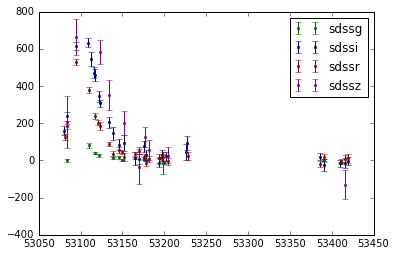

04D3dd 214.4516875 52.4706777778


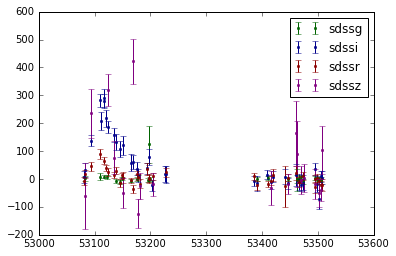

04D3df 214.541670833 52.2776861111


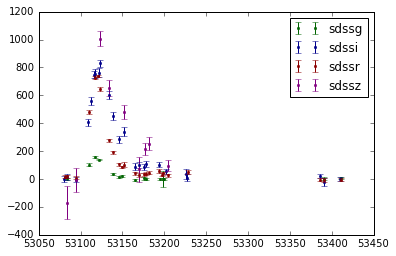

04D3do 214.442008333 52.2675527778


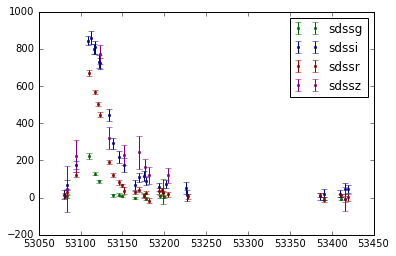

04D3ez 214.782641667 53.0719472222


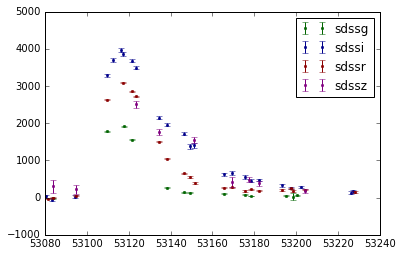

04D3fk 214.6091 52.5284666667


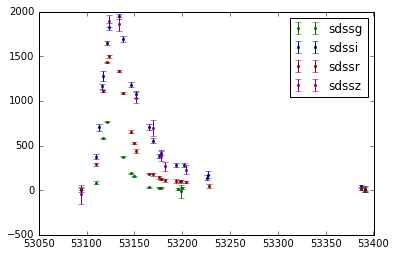

04D3fq 214.2411875 52.3794722222


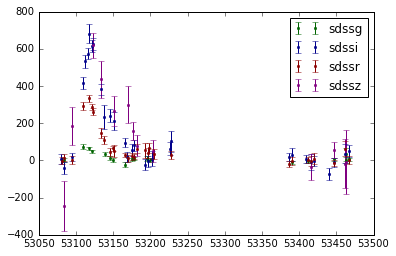

04D3gt 215.635795833 52.6469222222


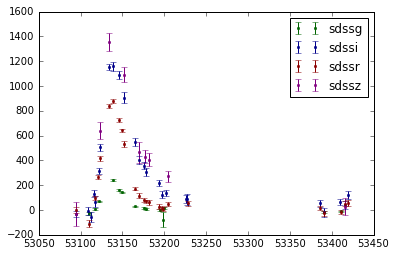

04D3gx 215.05695 52.2827777778


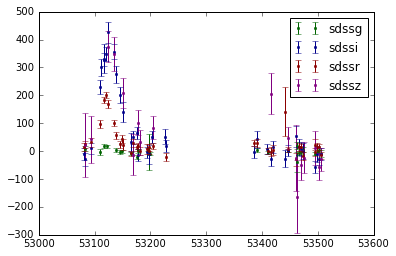

04D3hn 215.528729167 52.2285861111


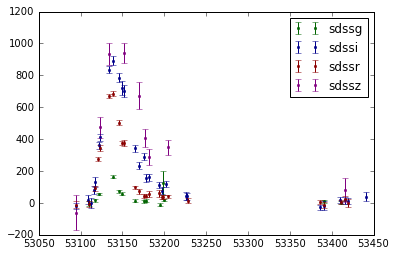

04D3kr 214.149725 52.478875


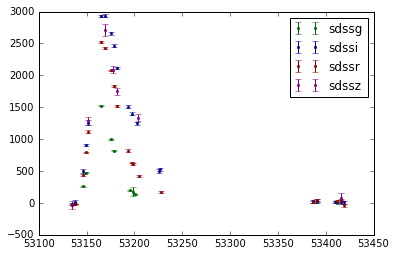

04D3ks 215.639779167 52.1851833333


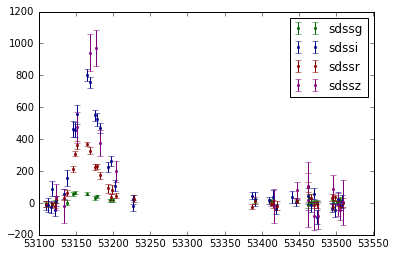

04D3lp 214.962120833 52.5031944444


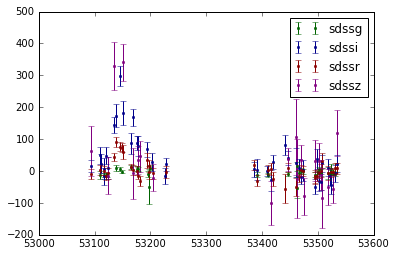

04D3lu 215.283208333 52.9747916667


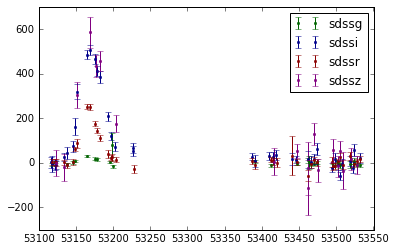

04D3mk 214.85735 53.1636944444


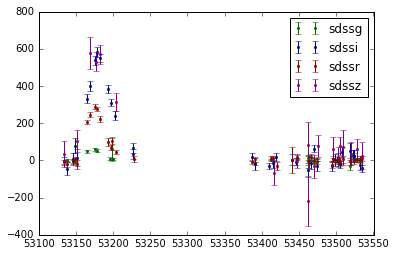

04D3ml 214.162783333 53.0932527778


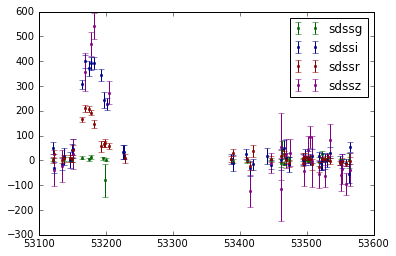

04D3nc 214.0759125 52.2738027778


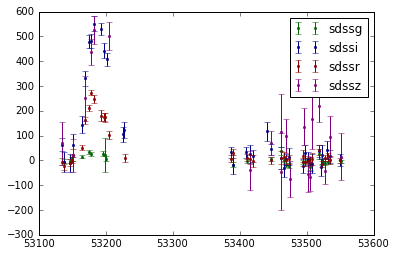

04D3nh 215.611283333 52.3334472222


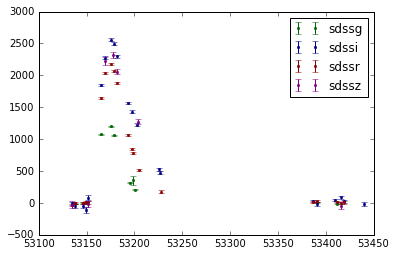

04D3nq 215.079729167 53.1544138889


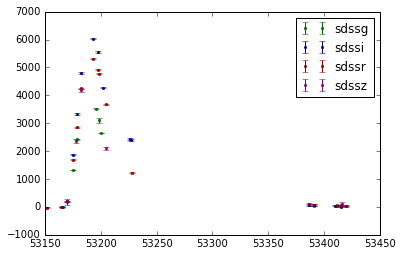

04D3nr 215.66045 52.6486861111


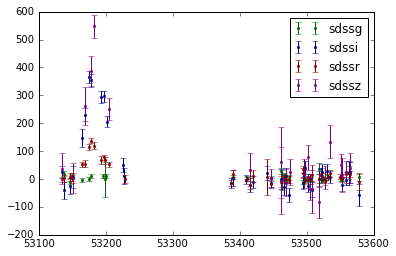

04D3ny 214.734666667 52.1874638889


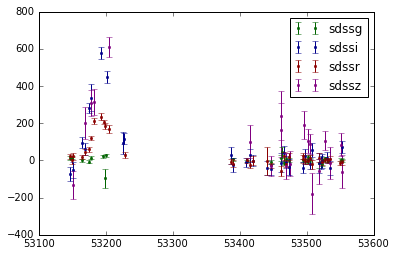

04D3oe 214.9141 52.5538472222


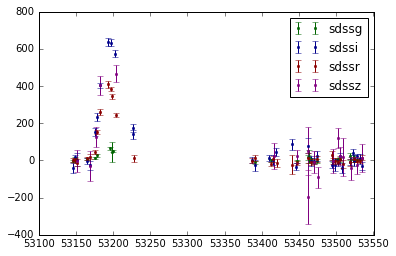

total of sn:25


In [51]:
%matplotlib inline
import re
import astropy.coordinates as coord
import astropy.units as u


f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
elems = re.findall('^(04D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()

snls_array = []
for sn in elems:
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    m = re.findall('^'+str(sn[0])+'\\|(r|g|z|i)\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

    snls_lc = DSTools.build_light_curve_from_snls_file(m, c)
    
    #print m
    print sn[0], c.ra.deg, c.dec.deg
    
    #plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
    show_multi_filter_light_curve(snls_lc, snls_colors)
    plt.show()
    snls_array.append(snls_lc)
    
print("total of sn:" + str(len(snls_array)))

In [52]:
def match_with_lc(snls_array, stack_lc):
    matches = []
    for lc in snls_array:
        #print "light curve"
        val = {"ra":lc[0]["ra"], "dec":lc[0]["dec"]}
        #print np.rad2deg(lc[0]["ra"]), np.rad2deg(lc[0]["dec"])
        for i, slc in enumerate(stack_lc):

            comp = {"ra":np.mean(slc["ra"]), "dec":np.mean(slc["dec"])}
            if DSTools.source_distance(val, comp)<1:
                print i
                matches.append((lc,slc))


    print len(matches)
    return matches

In [53]:
stats = []
for lc in tot_lcs:
    t_by_filter = lc.group_by("bandpass")
    indices = t_by_filter.groups.indices
    stats.append(len(indices)-1)
    

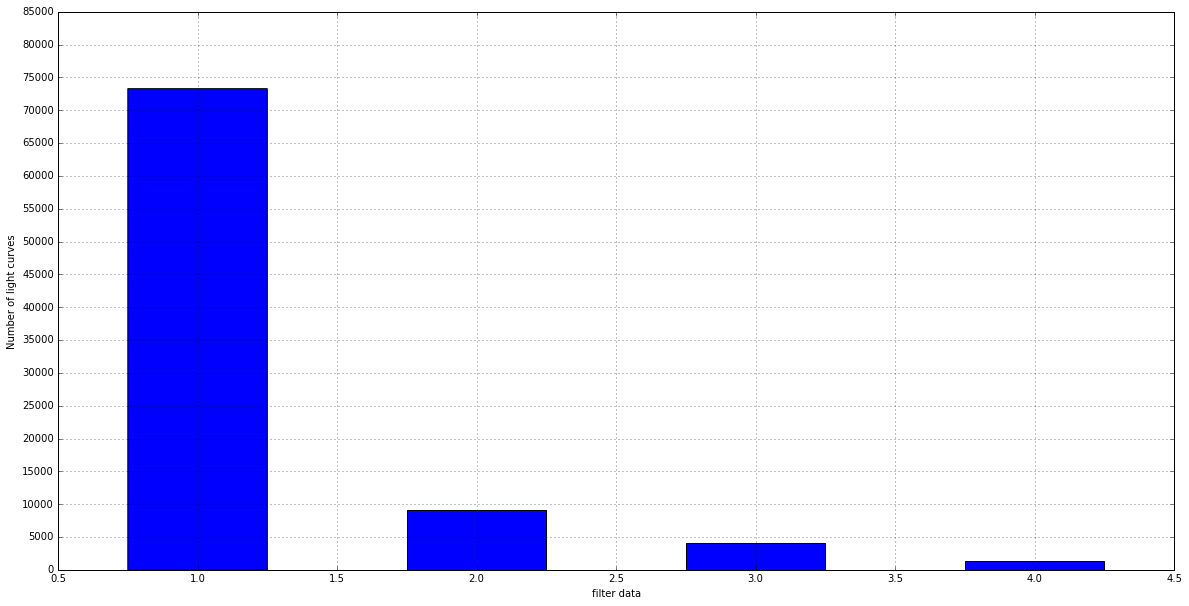

In [54]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.hist(stats, bins=range(1,6,1), align='left', rwidth=0.5)
plt.ylabel("Number of light curves")
plt.xlabel("filter data")
plt.yticks(np.arange(0,86000,5000))
plt.grid(True)
plt.show()

In [55]:
matches_45= match_with_lc(snls_array, tot_lcs)

63038
83326
8903
8951
71136
63050
79625
79821
21027
13233
18669
19296
33431
33778
67835
68116
48997
86492
75689
24853
42433
70183
27863
31169
23202
28865
28975
41847
42030
78852
79133
68493
16673
49041
76652
27127
52622
37


In [56]:
def normalize_light_curve(lc1, lc2, filter):
   
    l1 = lc1[lc1['bandpass']==filter]
    l2 = lc2[lc2['bandpass']==filter]
    norm = []
    for row1 in l1:
        for row2 in l2:
            if int(row1["mjd"]) == int(row2["mjd"]):
                norm.append(row1["flux"]/row2["flux"])
                
    c_array = sigmaclip(norm, low=1.5, high=1.5)
    return c_array.clipped.mean()

In [57]:
from scipy.stats import sigmaclip

214.43765177 52.4677524201
{'sdssi': 22.695001674552561, 'sdssr': 19.320470231897936, 'sdssz': 30.989054843146352, 'sdssg': 15.755094356878164}


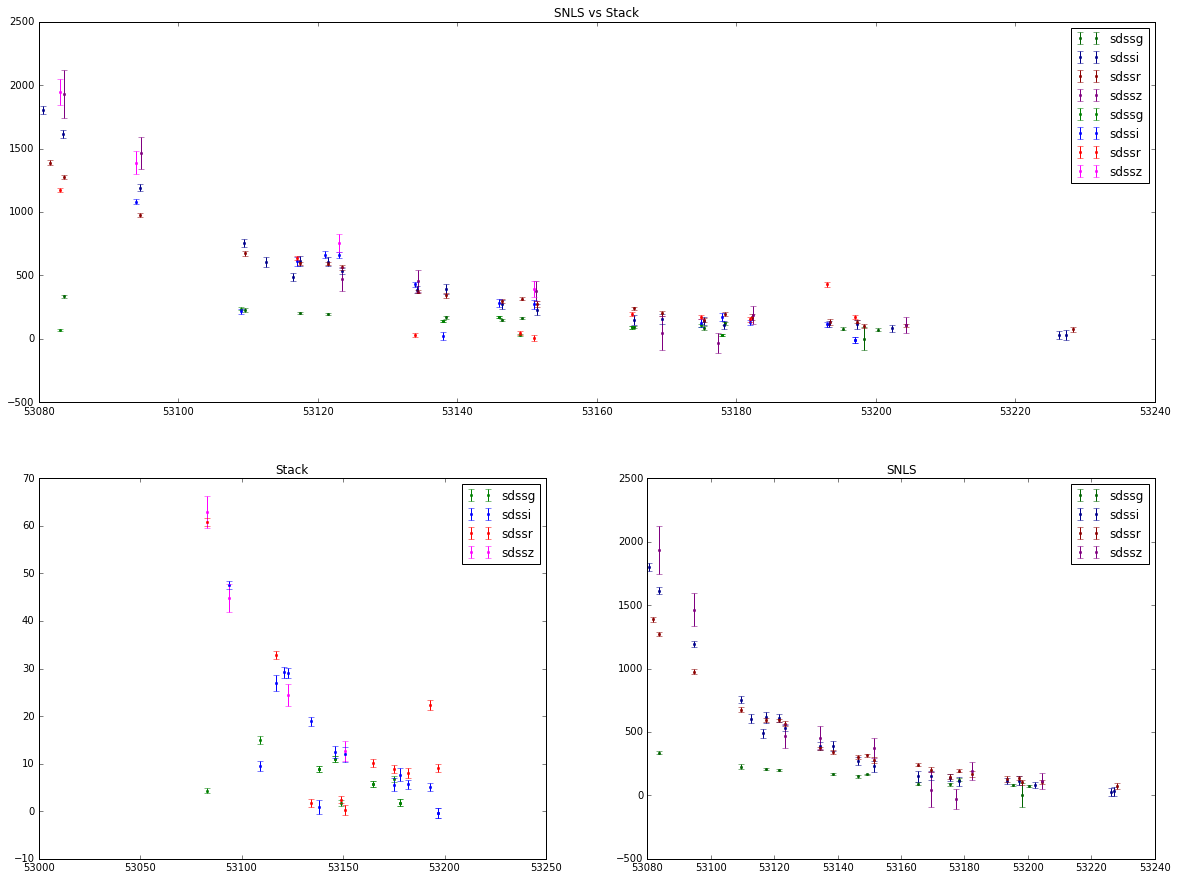

214.458301279 52.9635390022
{'sdssi': 24.139246176016499, 'sdssr': 21.207196671561352, 'sdssz': 29.695606287536918, 'sdssg': nan}


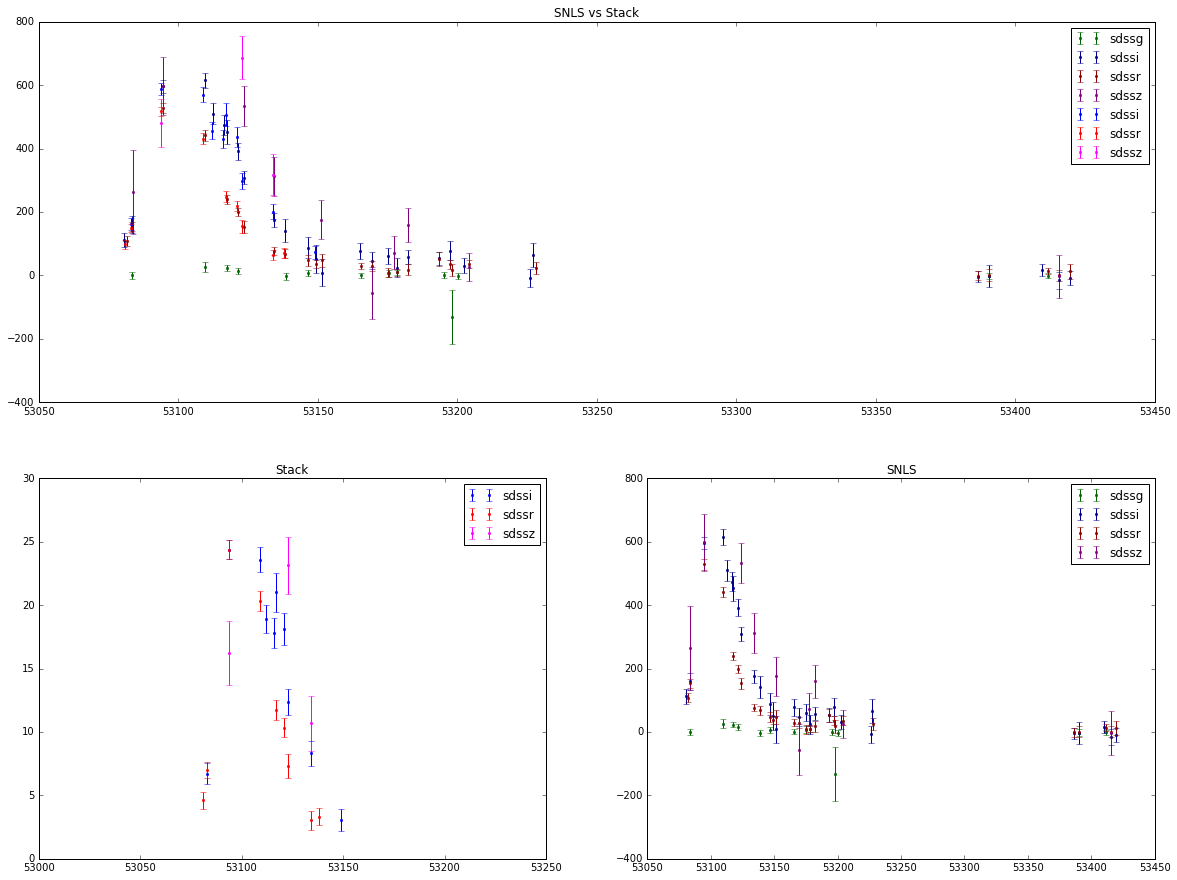

215.099758337 52.8208809133
{'sdssi': nan, 'sdssr': 21.27316524160128, 'sdssz': nan, 'sdssg': nan}


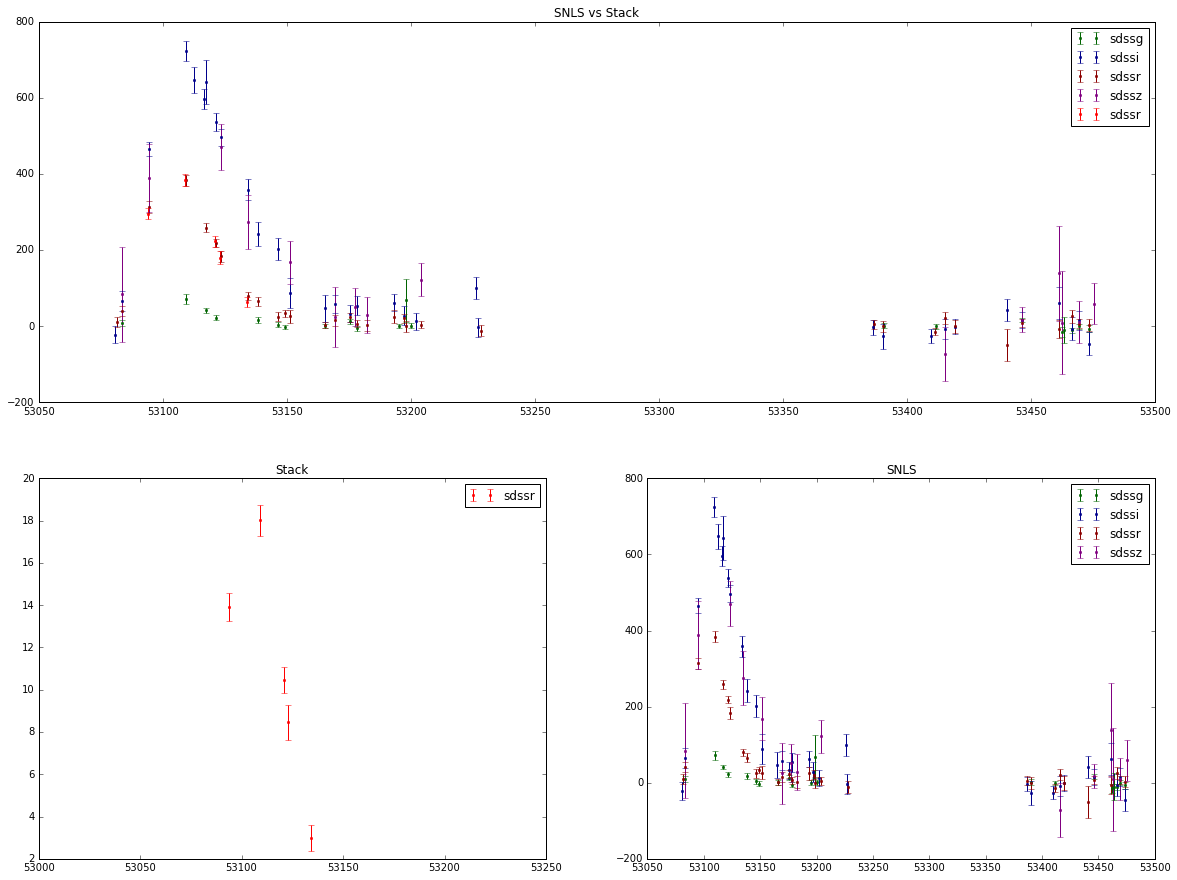

215.099520256 52.8207065675
{'sdssi': 20.17407626371908, 'sdssr': nan, 'sdssz': nan, 'sdssg': nan}


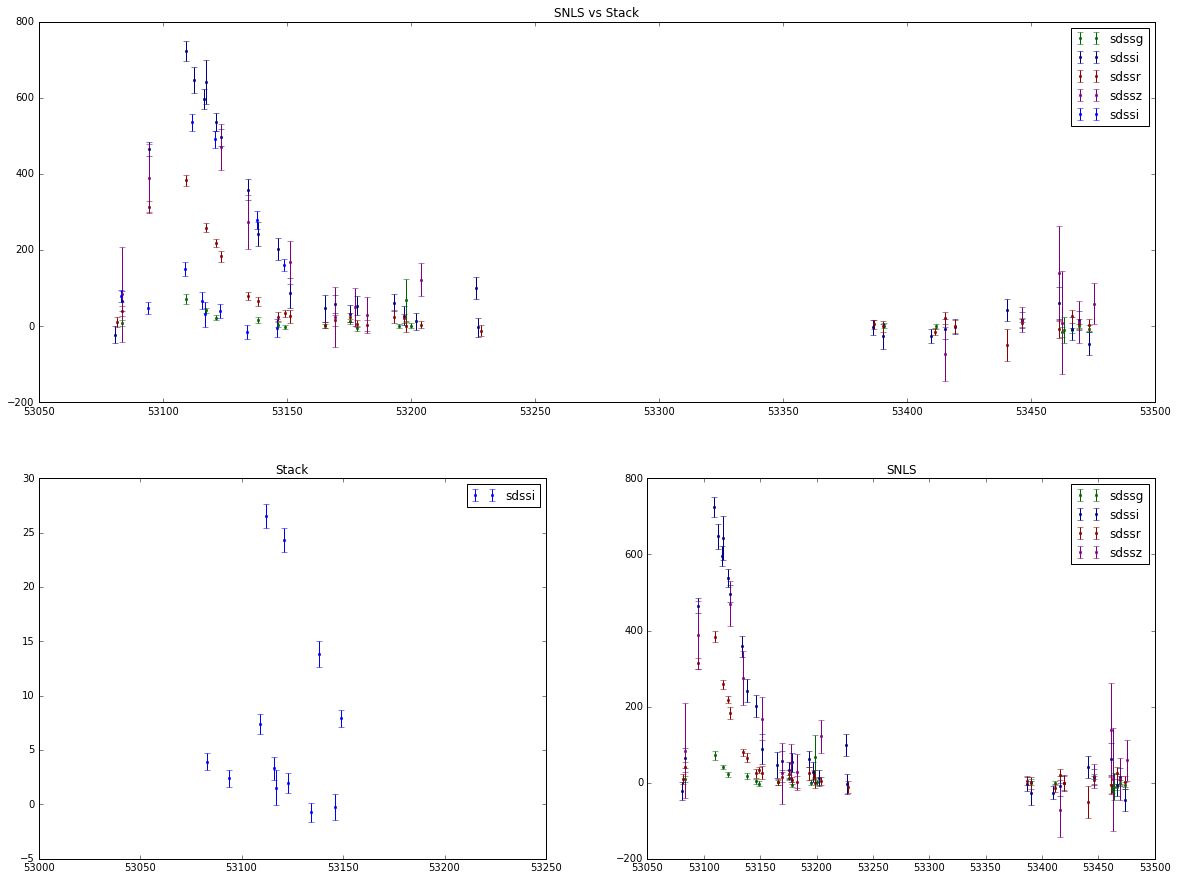

214.551764142 52.6583912264
{'sdssi': 22.700477399566736, 'sdssr': 21.940007223263152, 'sdssz': nan, 'sdssg': 9.0061134829848246}


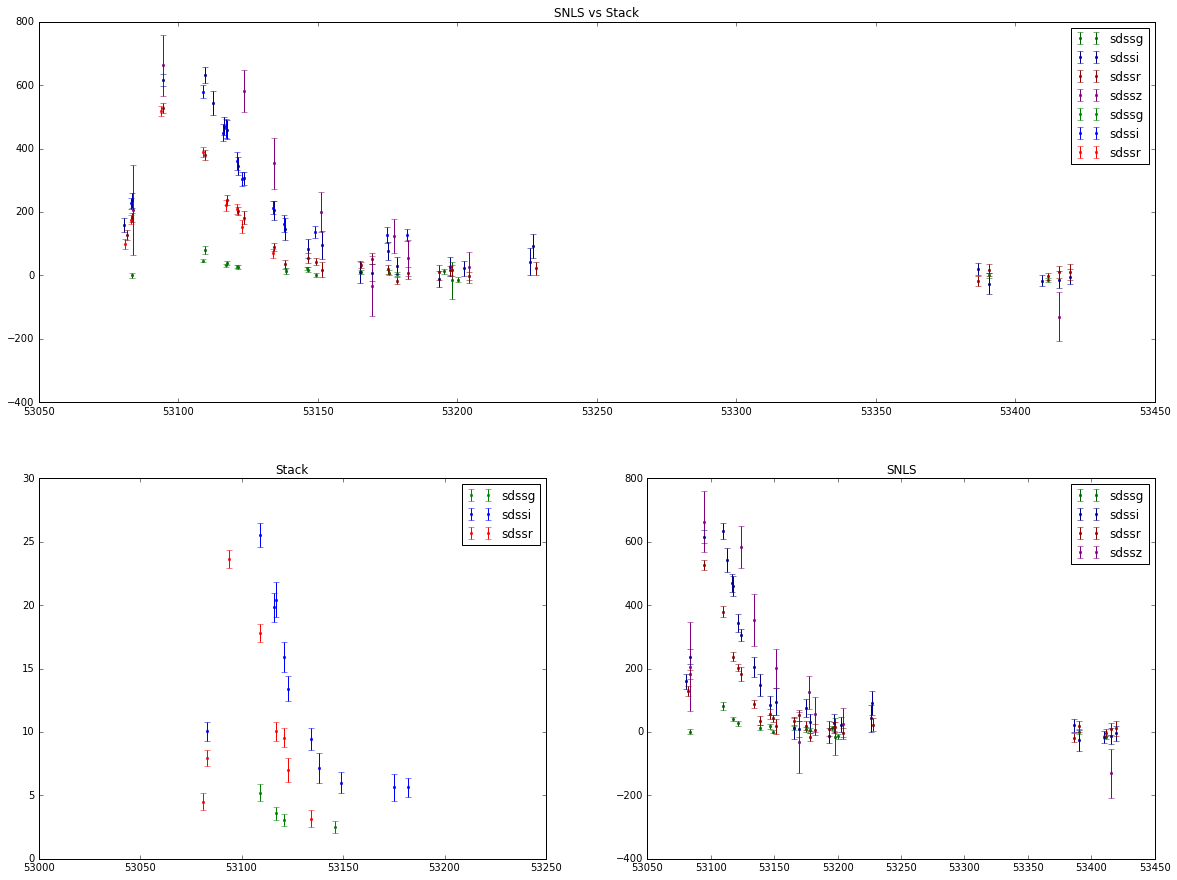

214.451605558 52.4706717781
{'sdssi': 24.283347144806275, 'sdssr': 17.599651192760408, 'sdssz': nan, 'sdssg': nan}


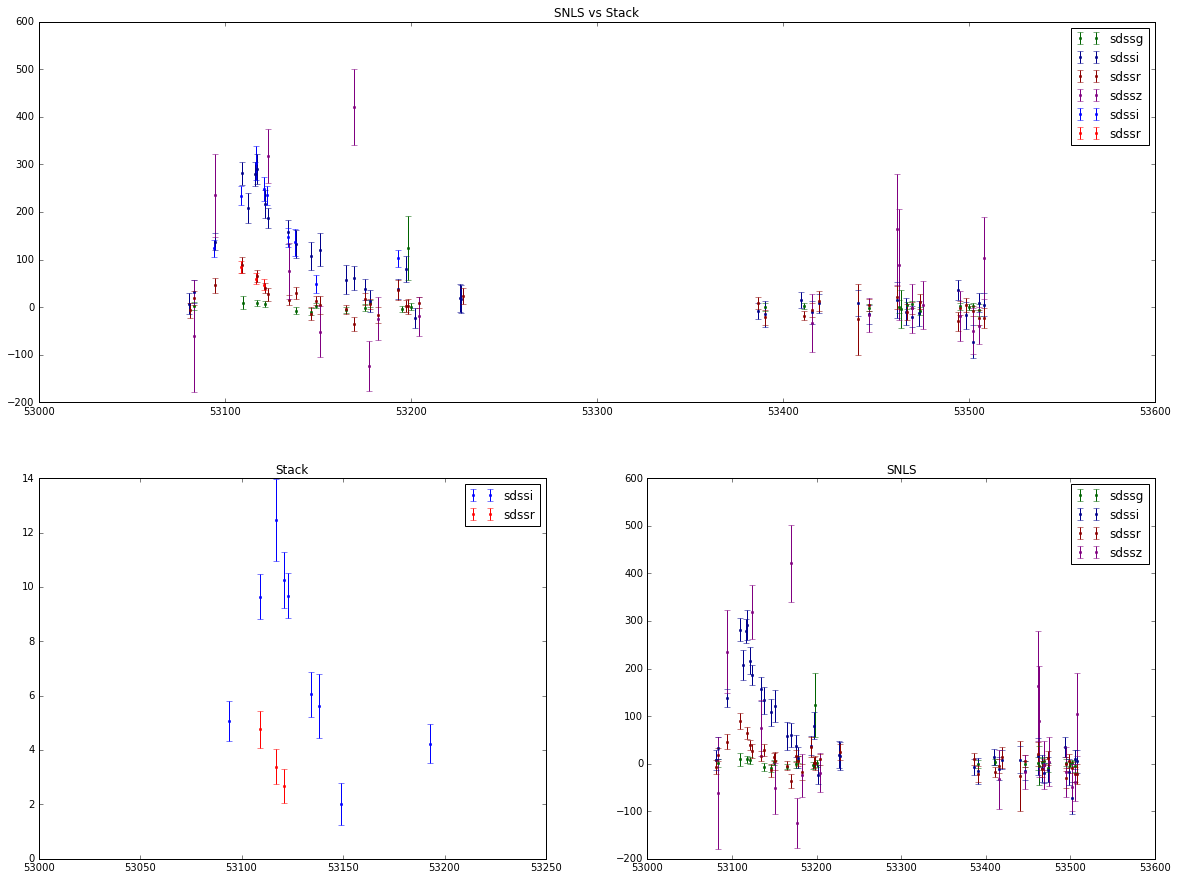

214.541571755 52.2776960676
{'sdssi': 25.413934904033514, 'sdssr': 19.005411236491465, 'sdssz': 25.44512497862371, 'sdssg': 17.681493697067811}


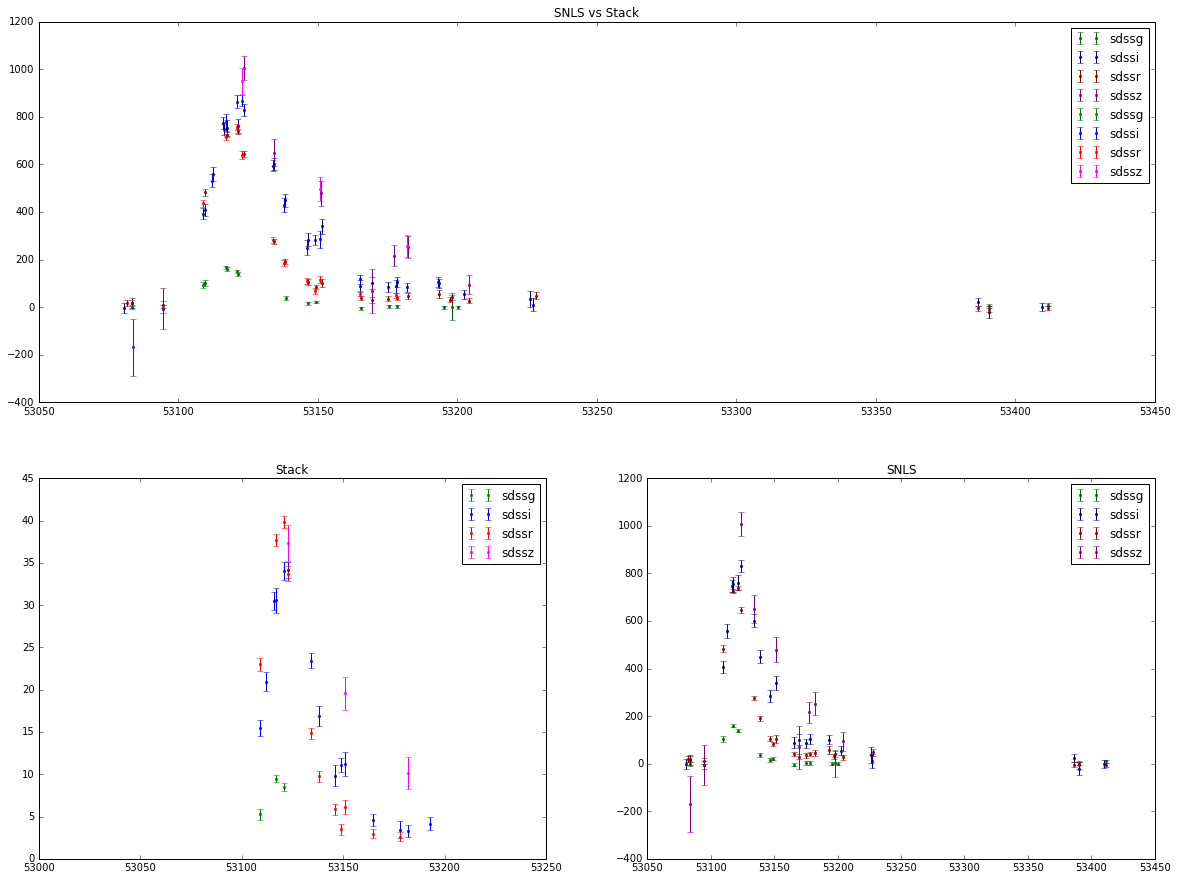

214.54157124 52.2776956267
{'sdssi': 25.293716450813086, 'sdssr': 18.922361897647619, 'sdssz': 25.74814300598814, 'sdssg': 17.770633975314187}


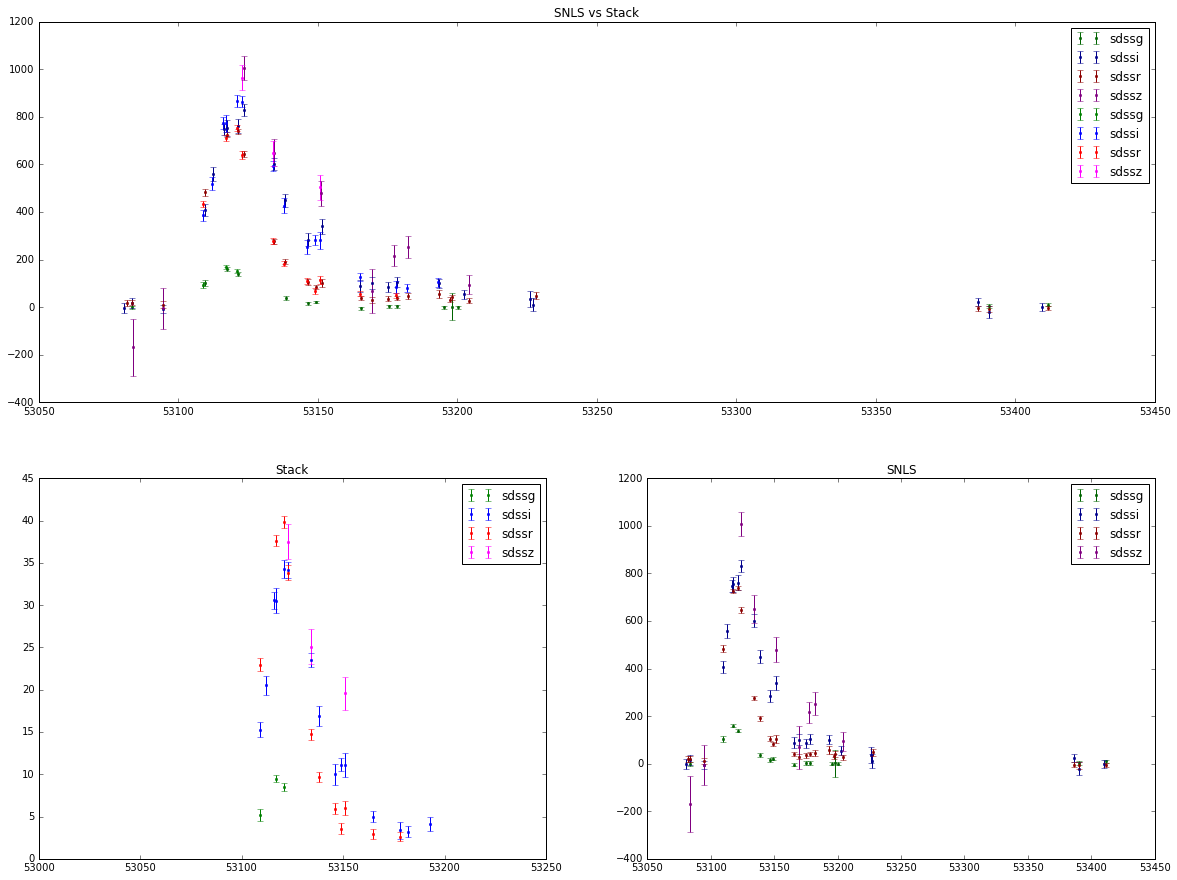

214.441900366 52.2675713346
{'sdssi': 26.064561389397117, 'sdssr': 19.082383807328732, 'sdssz': 25.576998678280049, 'sdssg': 15.60783721753562}


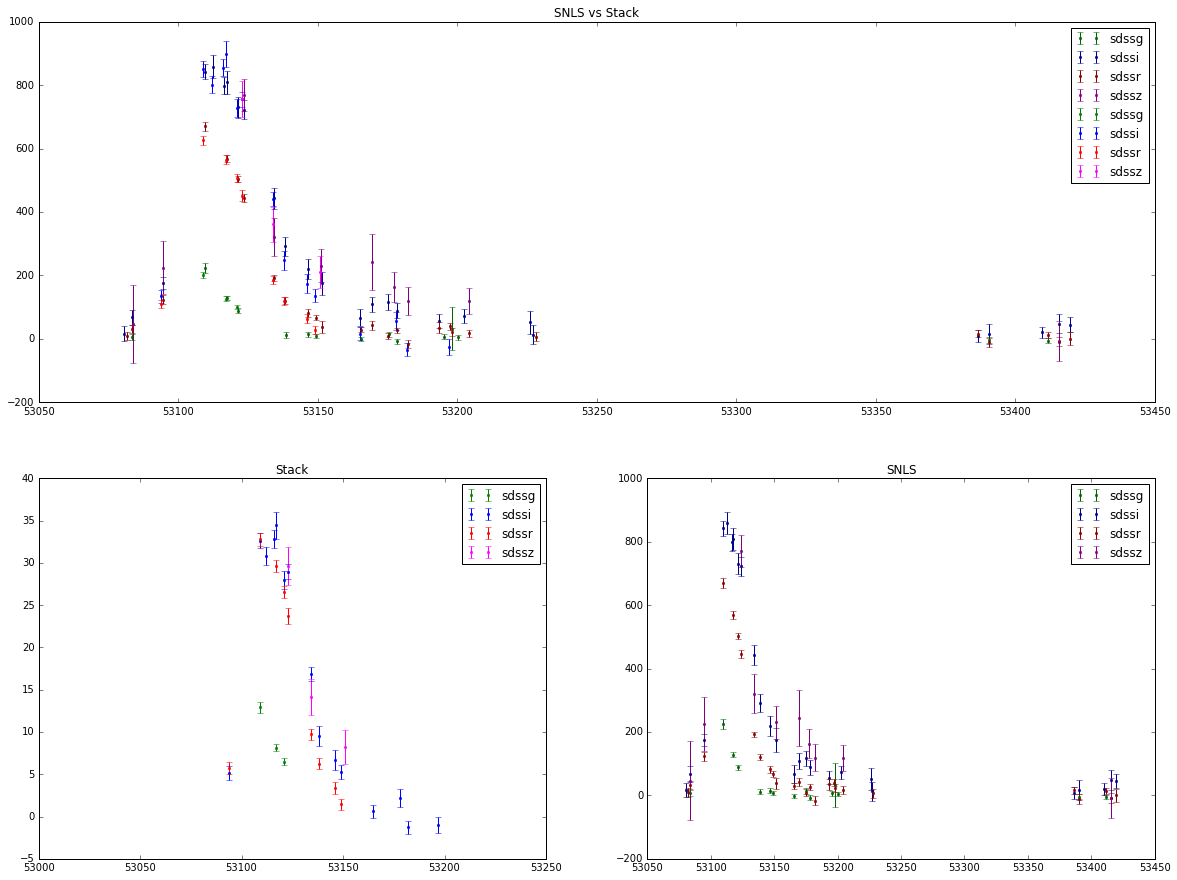

214.782738477 53.0719229683
{'sdssi': 24.890428796686727, 'sdssr': 19.420146631541019, 'sdssz': nan, 'sdssg': 16.28714340900207}


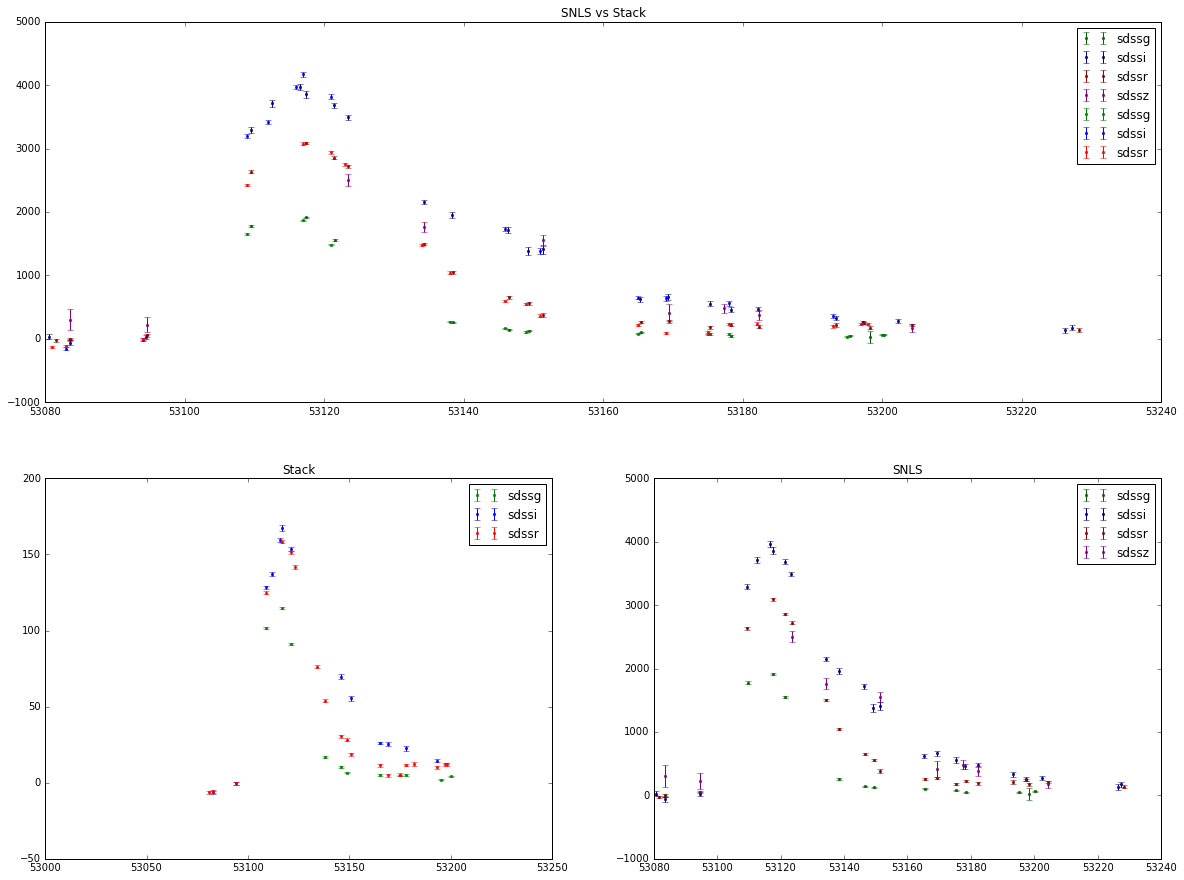

214.60898784 52.5286396524
{'sdssi': nan, 'sdssr': nan, 'sdssz': nan, 'sdssg': nan}


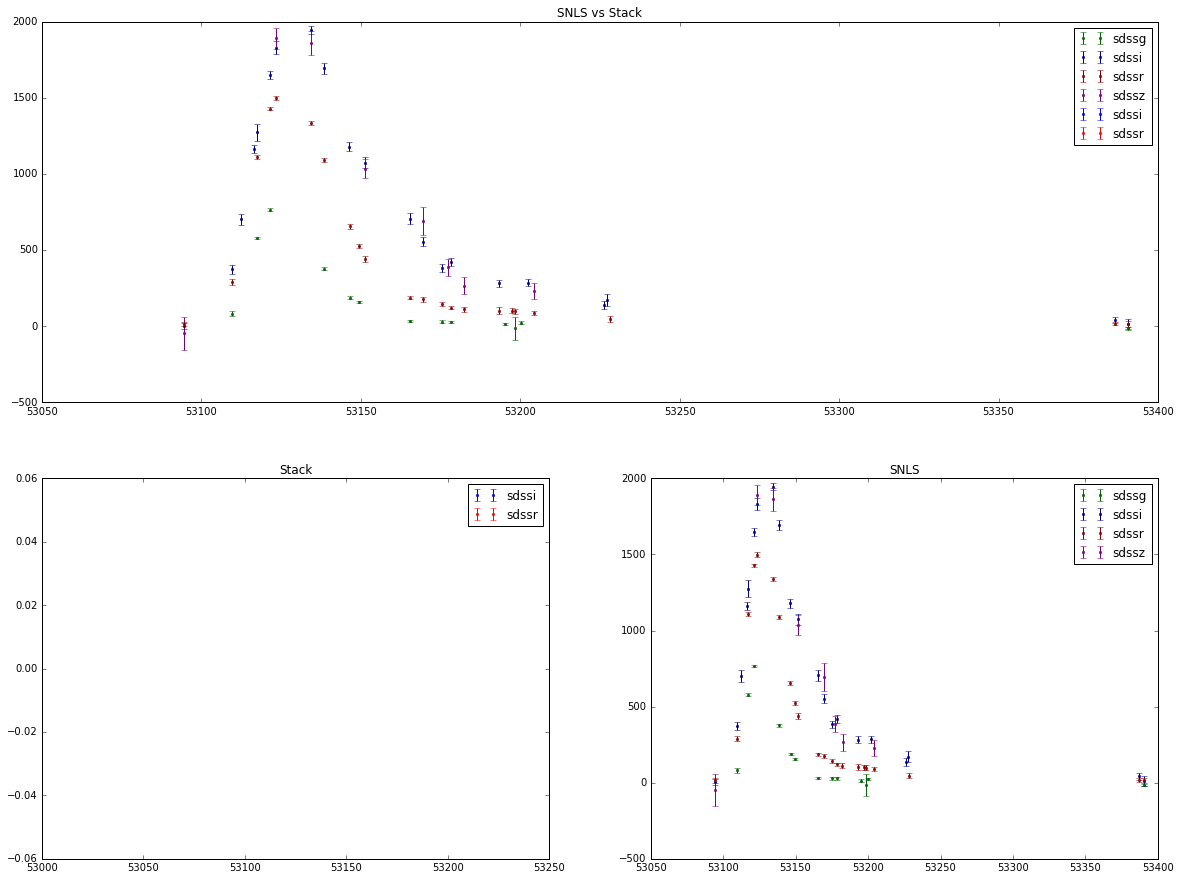

214.608975846 52.5284778702
{'sdssi': 23.599176146874562, 'sdssr': 20.444757036979674, 'sdssz': nan, 'sdssg': 15.520052228912812}


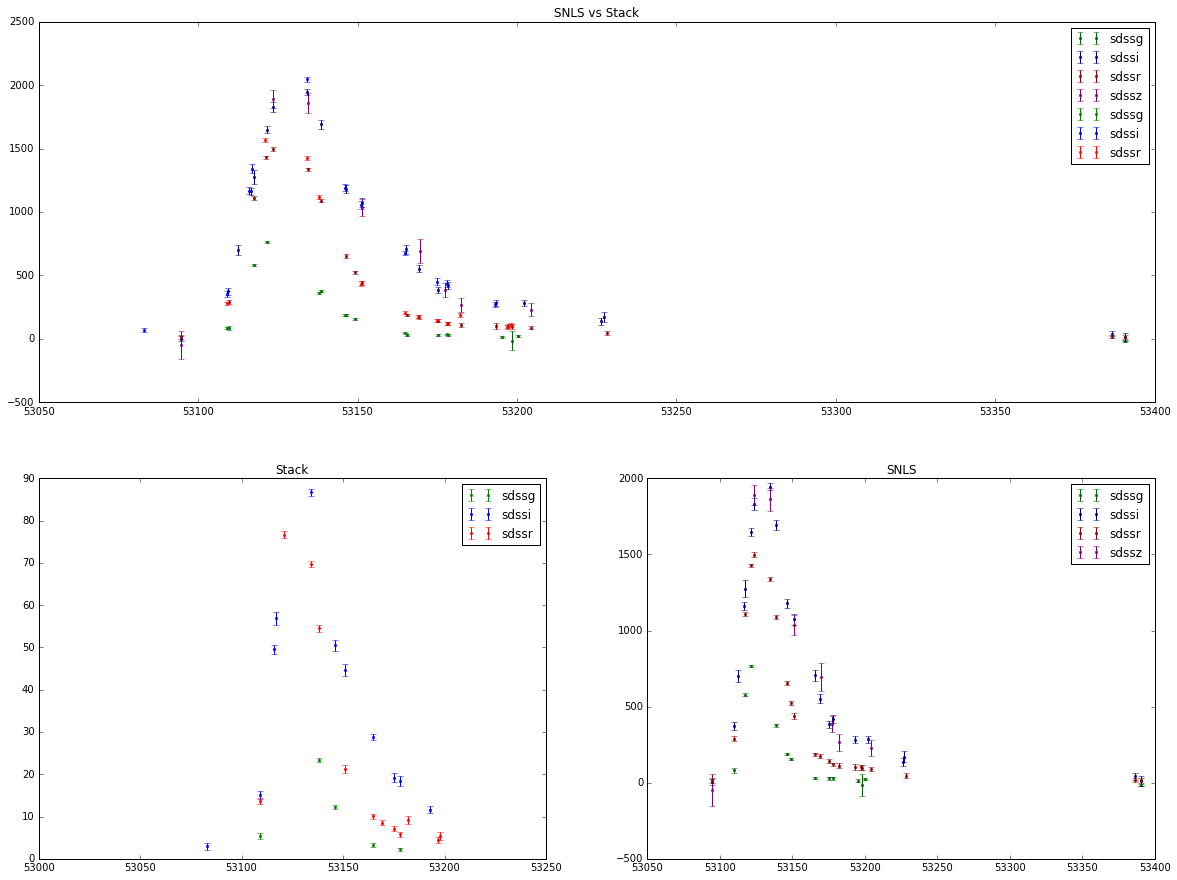

214.24110417 52.3795188623
{'sdssi': 24.560693899906862, 'sdssr': 20.411200737313472, 'sdssz': nan, 'sdssg': 15.501191731259127}


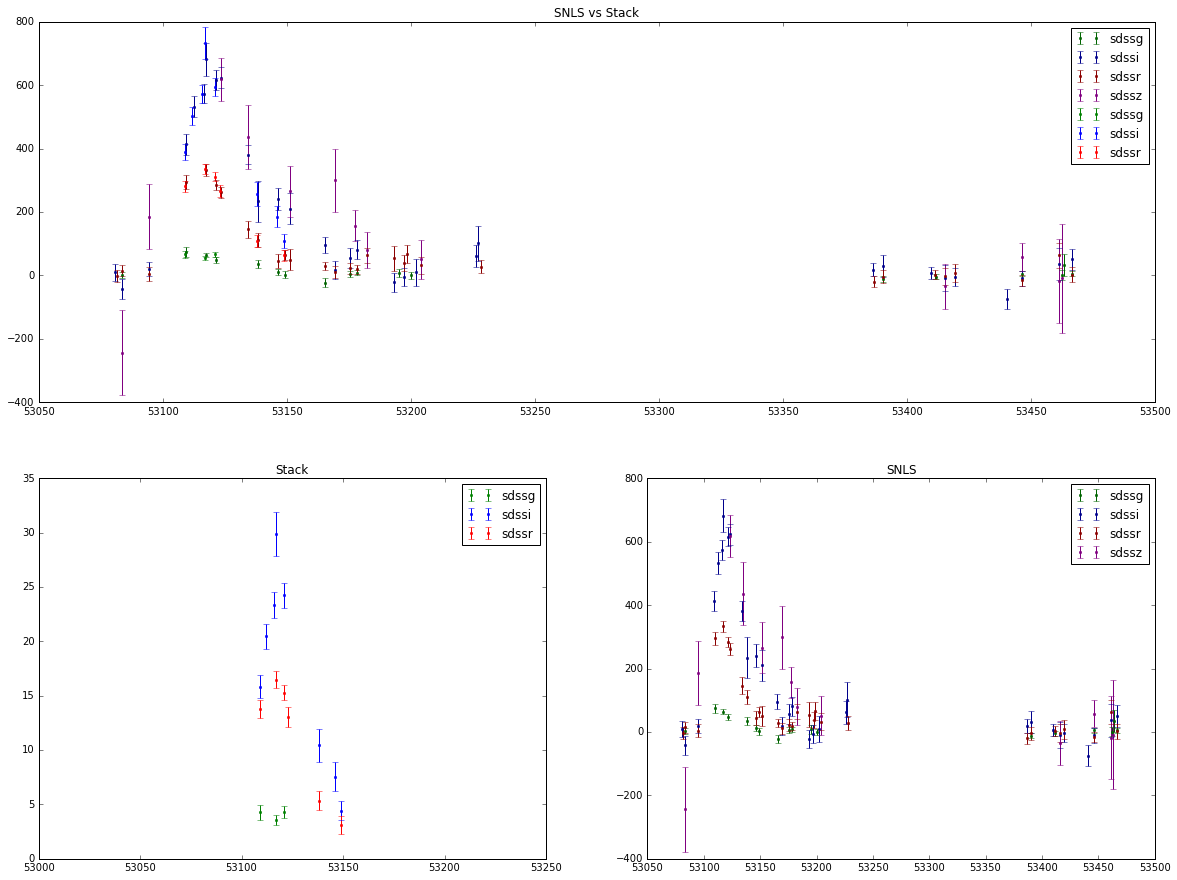

214.241110107 52.3795347279
{'sdssi': 24.61004987729472, 'sdssr': 20.376222727325487, 'sdssz': nan, 'sdssg': 56.184329337610187}


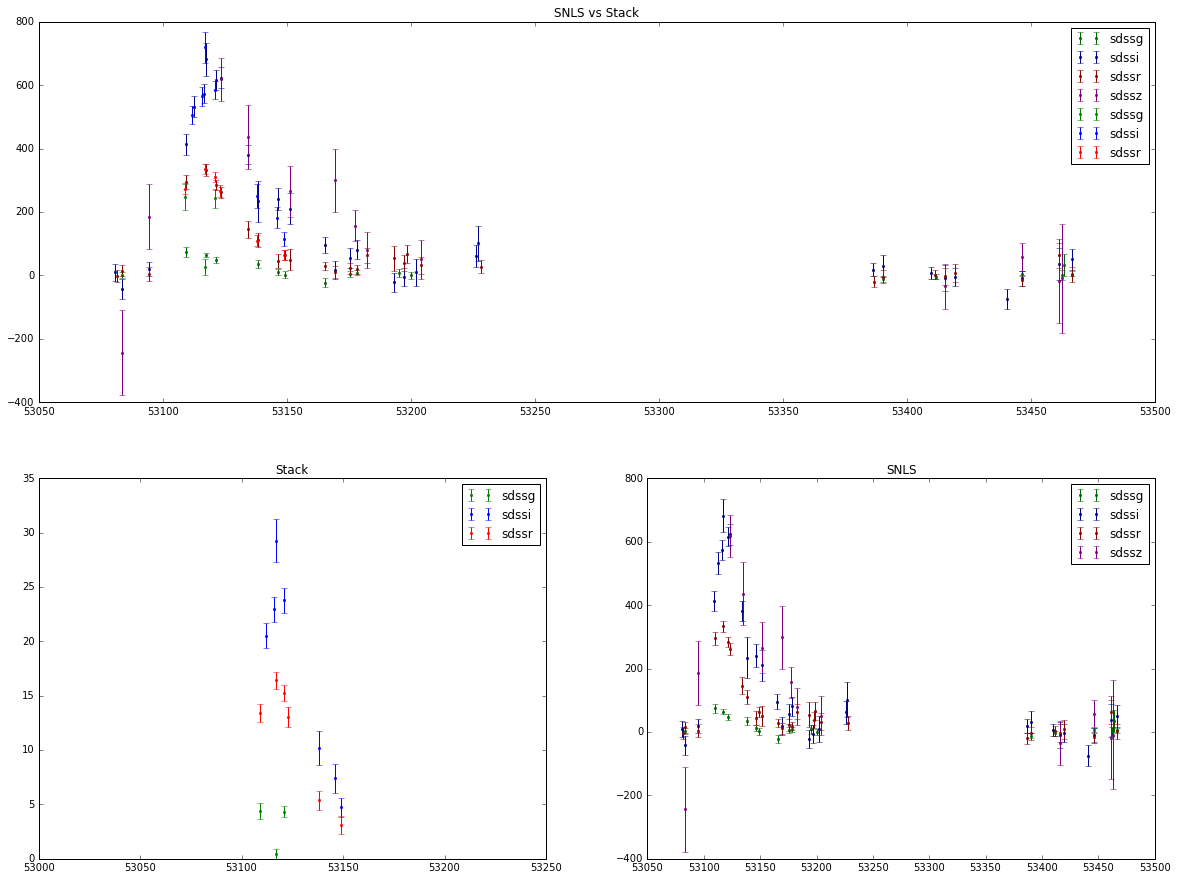

214.24109844 52.3795114034
{'sdssi': 23.883453355734499, 'sdssr': 20.854796624213712, 'sdssz': nan, 'sdssg': nan}


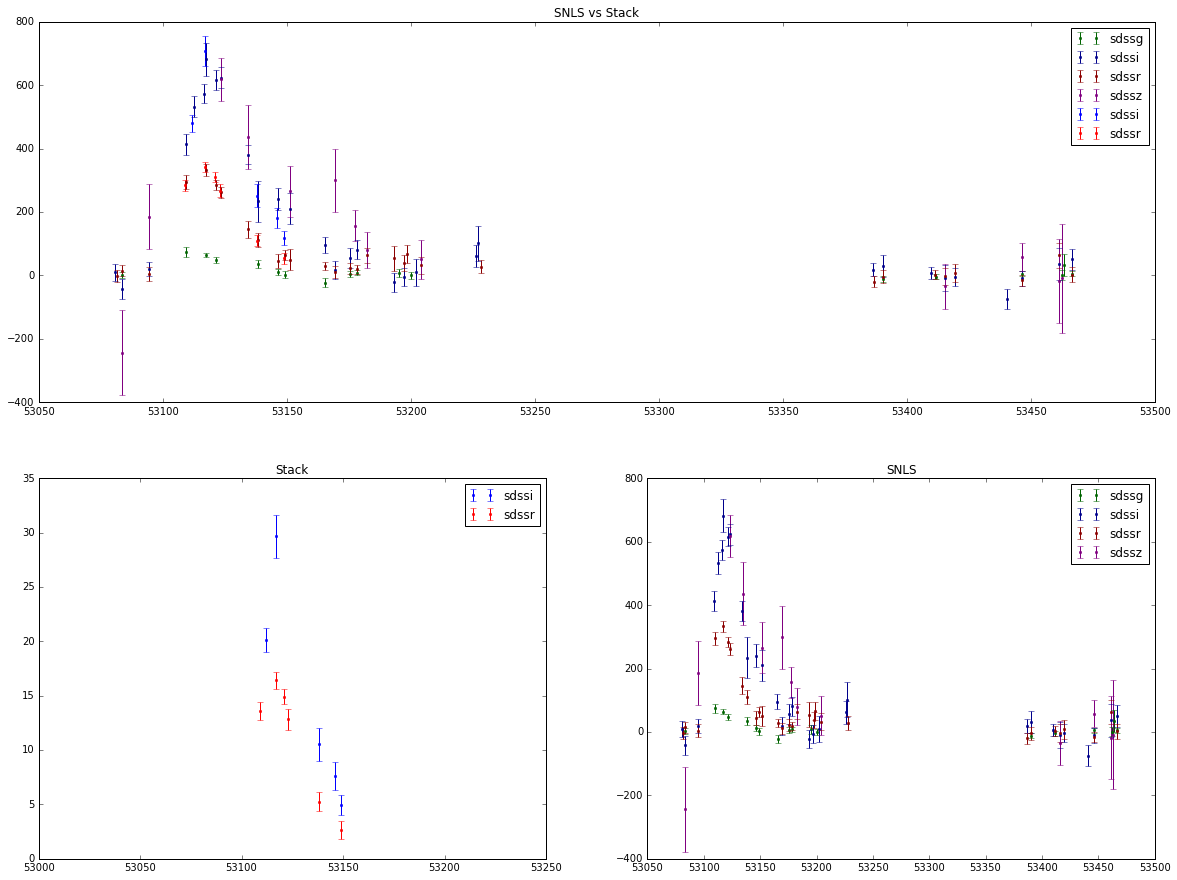

214.241099172 52.3795134662
{'sdssi': 24.423359638988487, 'sdssr': 19.900057547486917, 'sdssz': nan, 'sdssg': nan}


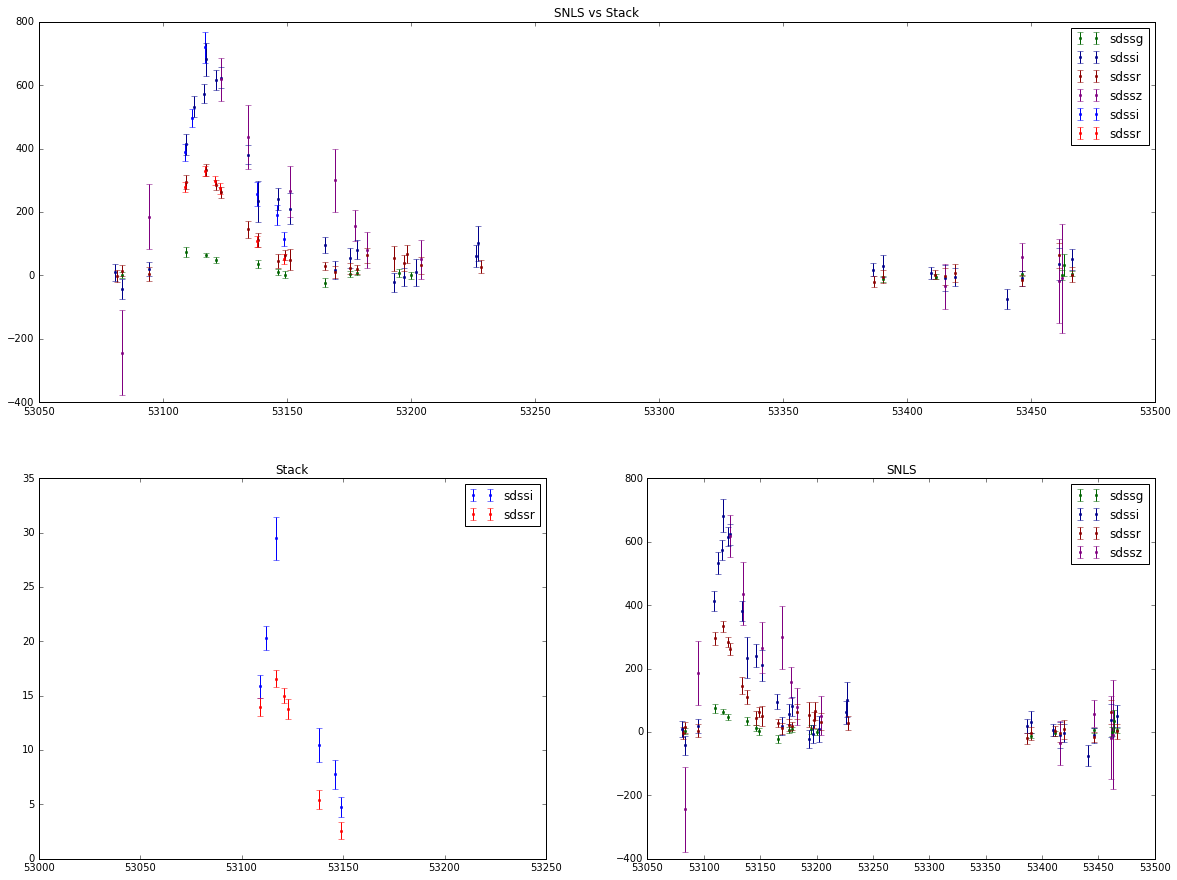

215.635703243 52.6469982231
{'sdssi': 23.760791329199883, 'sdssr': 19.134241561394568, 'sdssz': 28.065656968094757, 'sdssg': 15.737960842441458}


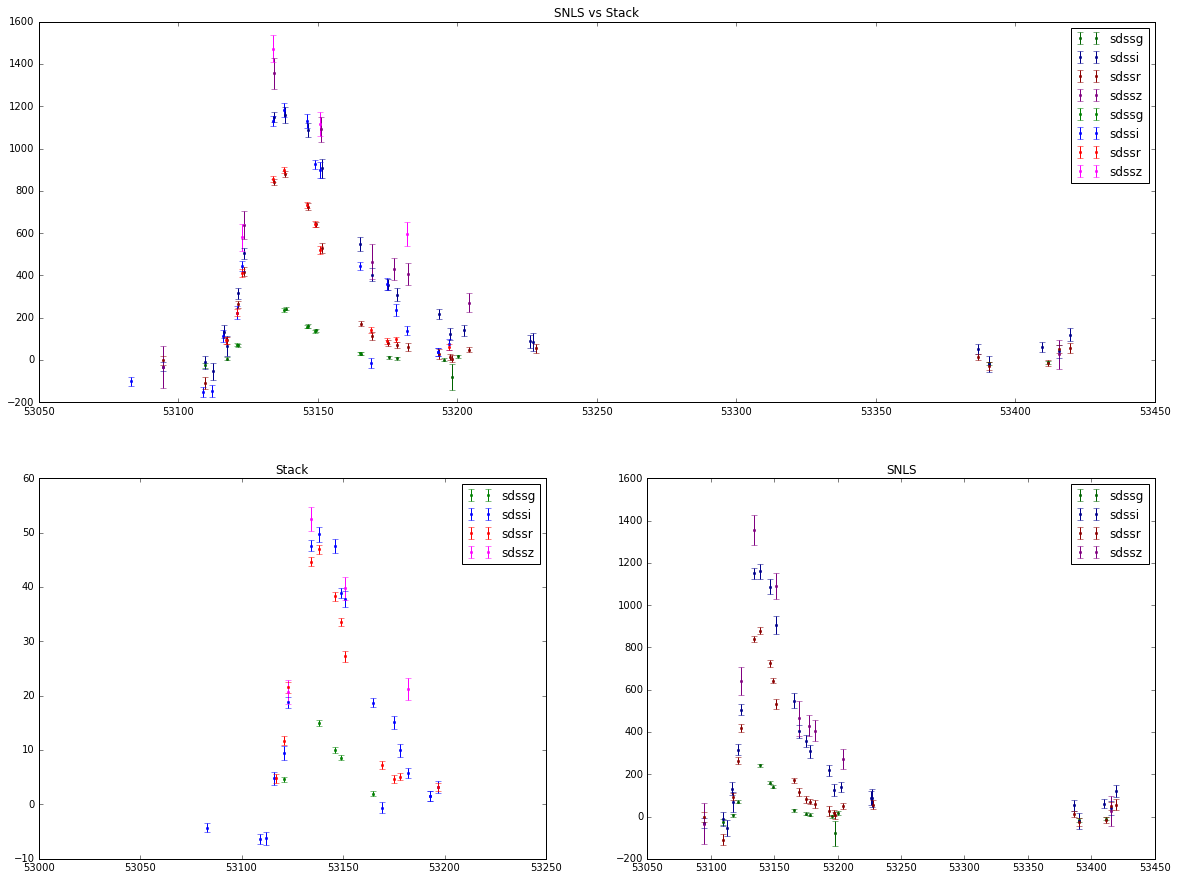

215.056777593 52.2828392276
{'sdssi': 24.657689493023813, 'sdssr': 18.199249147363112, 'sdssz': nan, 'sdssg': nan}


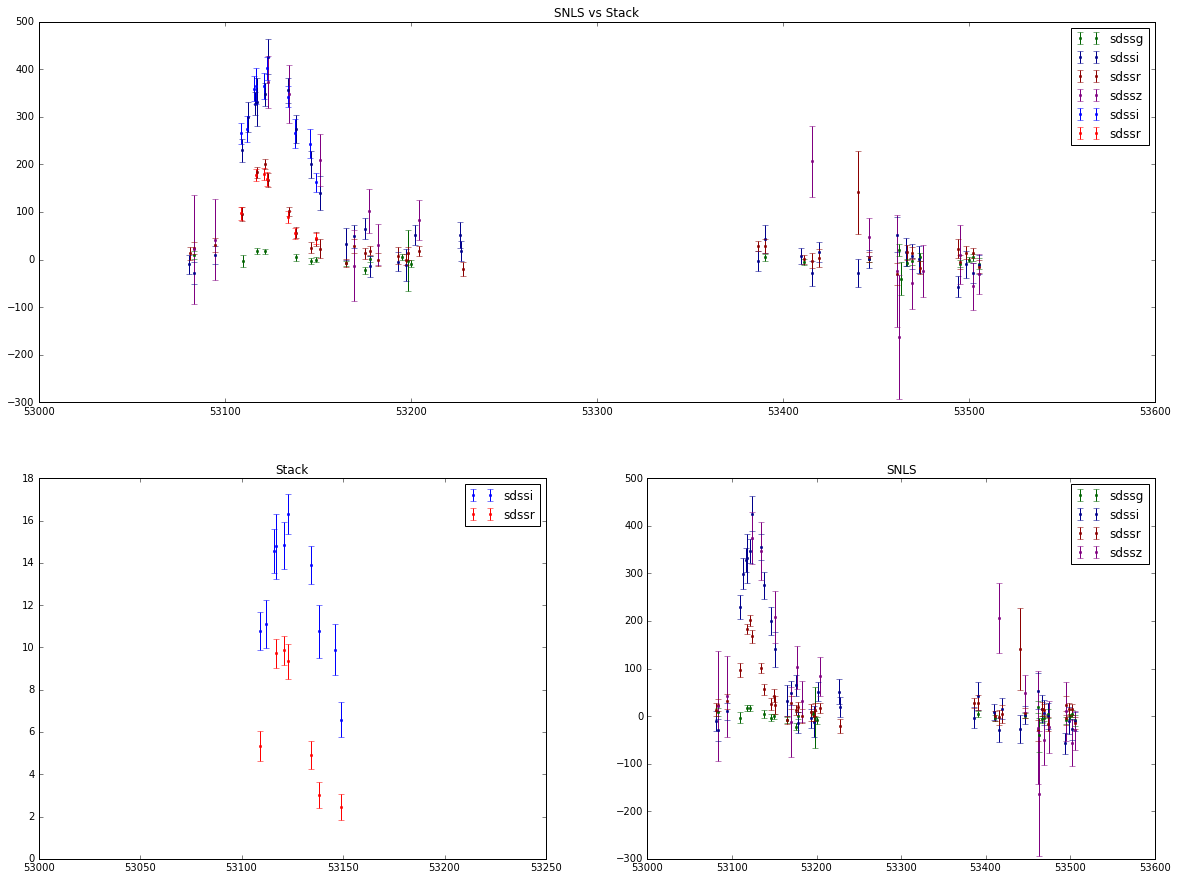

215.528591585 52.2286378231
{'sdssi': 25.321822407064314, 'sdssr': 21.133881721766869, 'sdssz': nan, 'sdssg': 16.499013075966573}


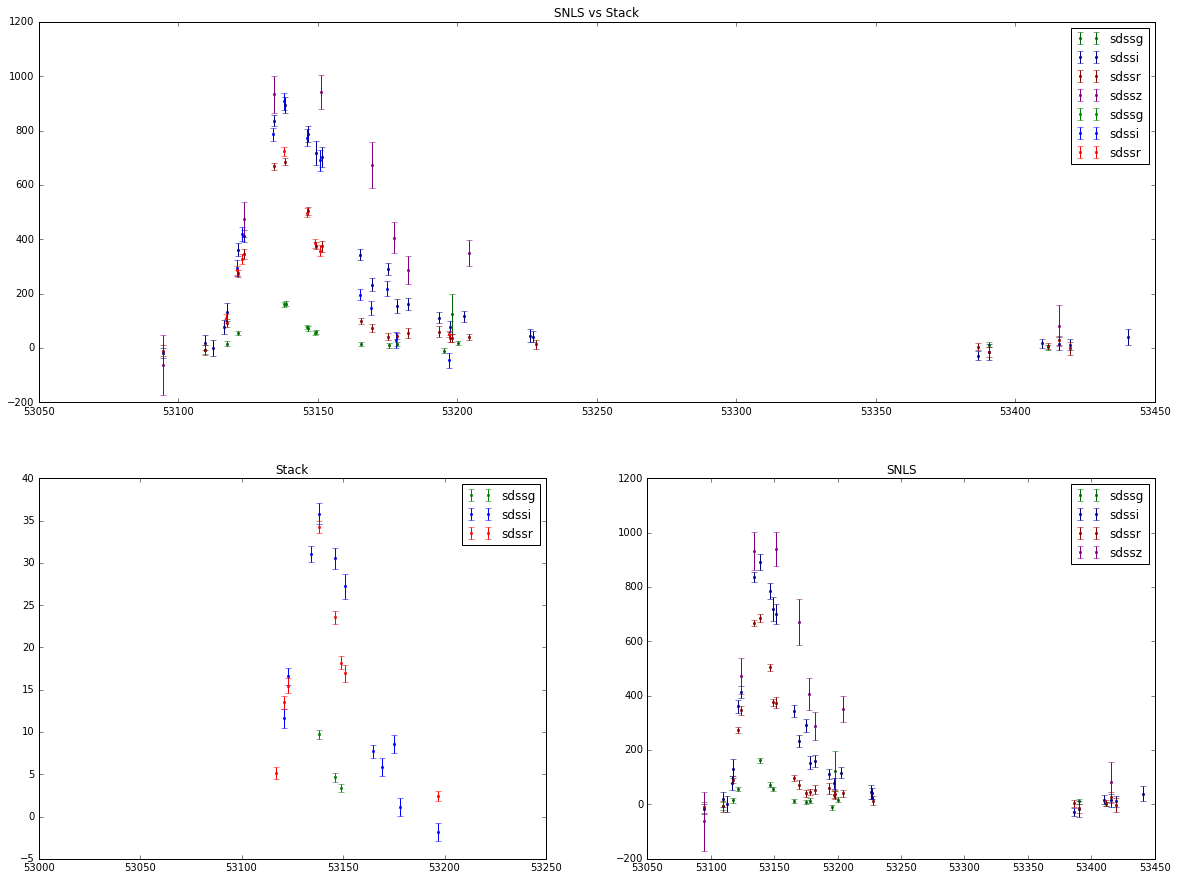

214.149582694 52.4789289326
{'sdssi': 23.628814471539702, 'sdssr': 20.137767861085781, 'sdssz': nan, 'sdssg': 16.468402665941881}


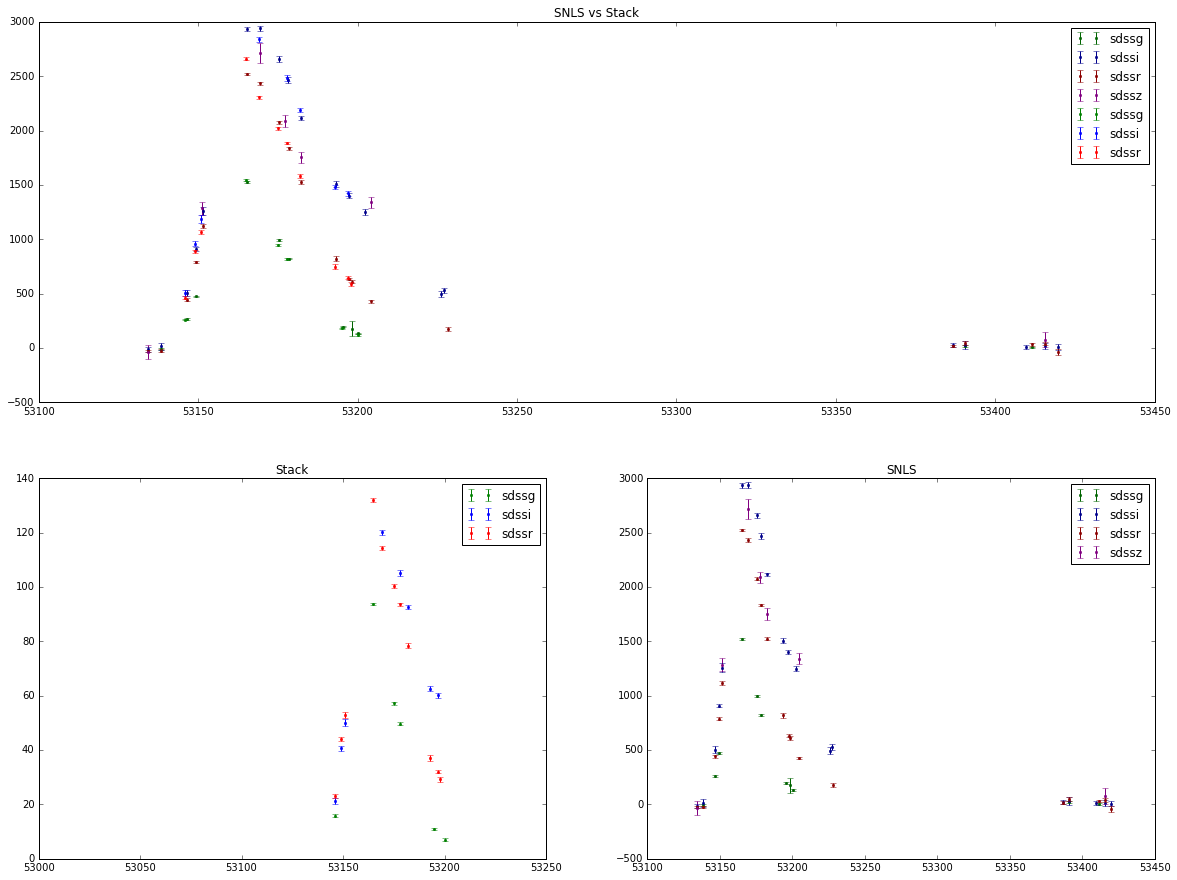

214.149562265 52.4789255718
{'sdssi': 23.958224001701996, 'sdssr': 19.502979771675683, 'sdssz': nan, 'sdssg': 16.692659167095982}


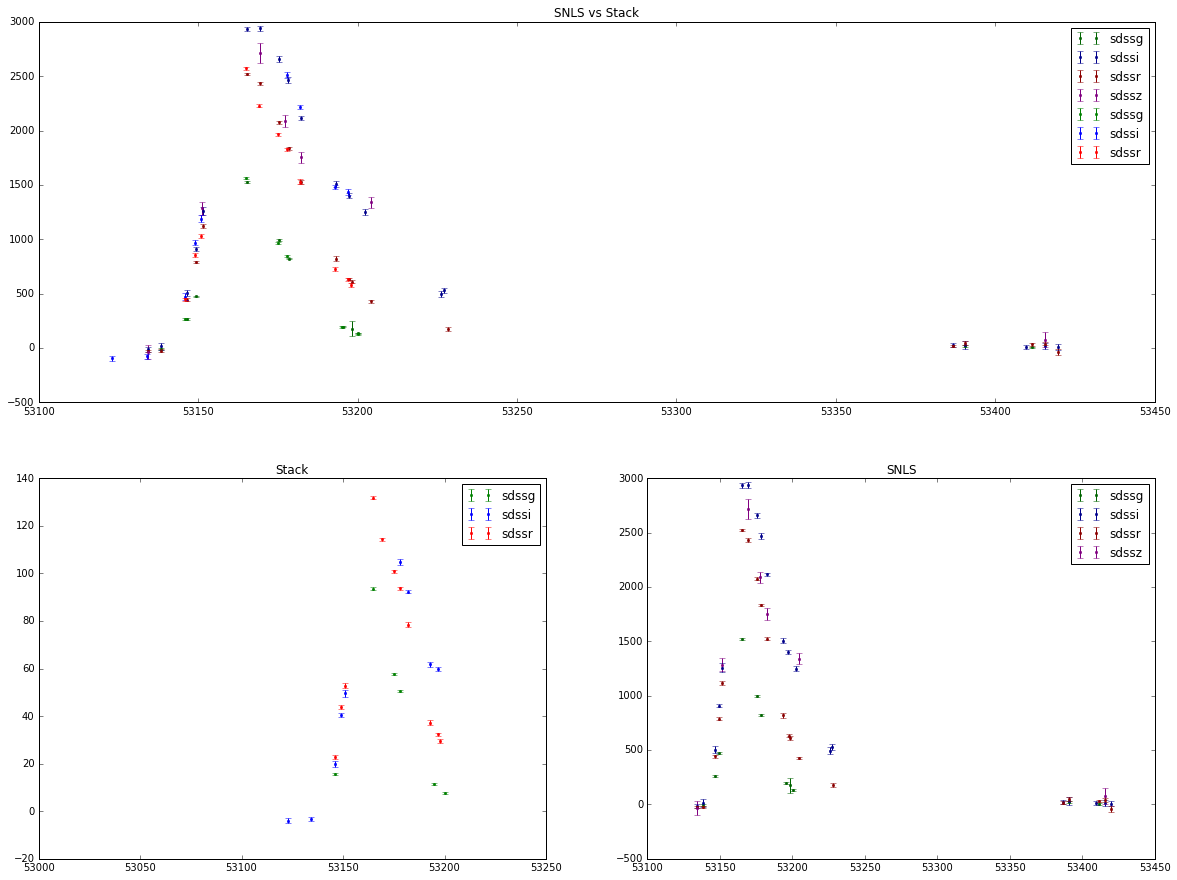

215.639658334 52.1852607168
{'sdssi': 24.050100131258624, 'sdssr': 21.000910169220983, 'sdssz': nan, 'sdssg': nan}


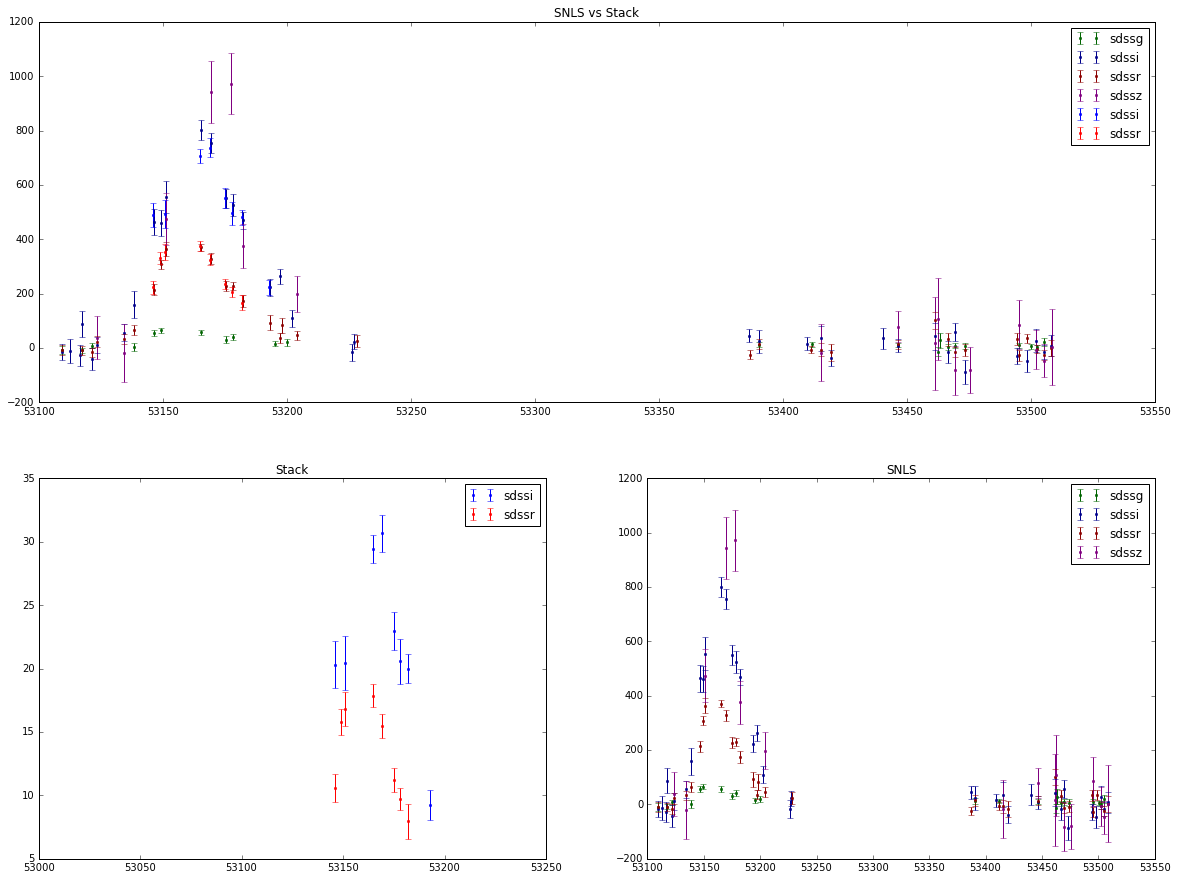

214.962043277 52.5032096549
{'sdssi': 23.843805867152174, 'sdssr': 17.649199664306284, 'sdssz': nan, 'sdssg': nan}


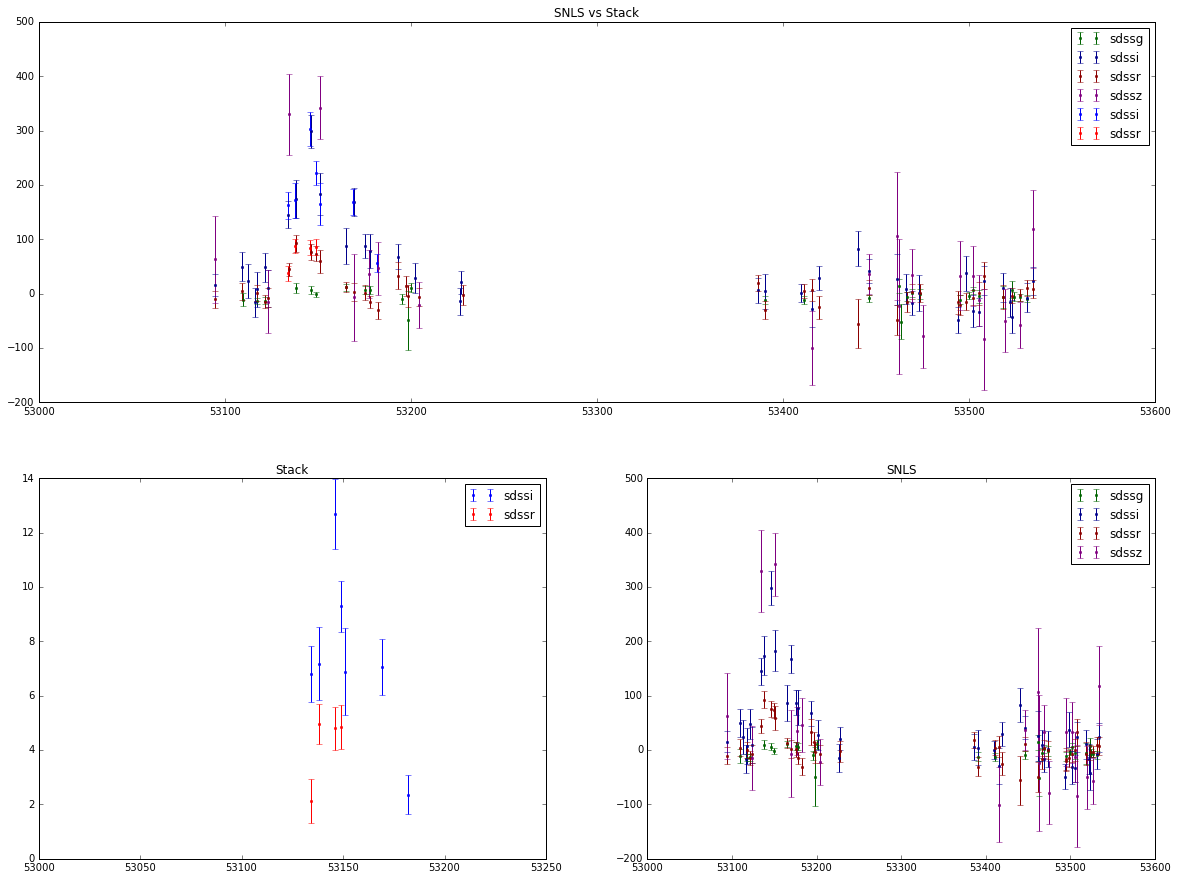

215.283318818 52.9747302141
{'sdssi': 25.065691103745245, 'sdssr': 18.34737222413704, 'sdssz': nan, 'sdssg': nan}


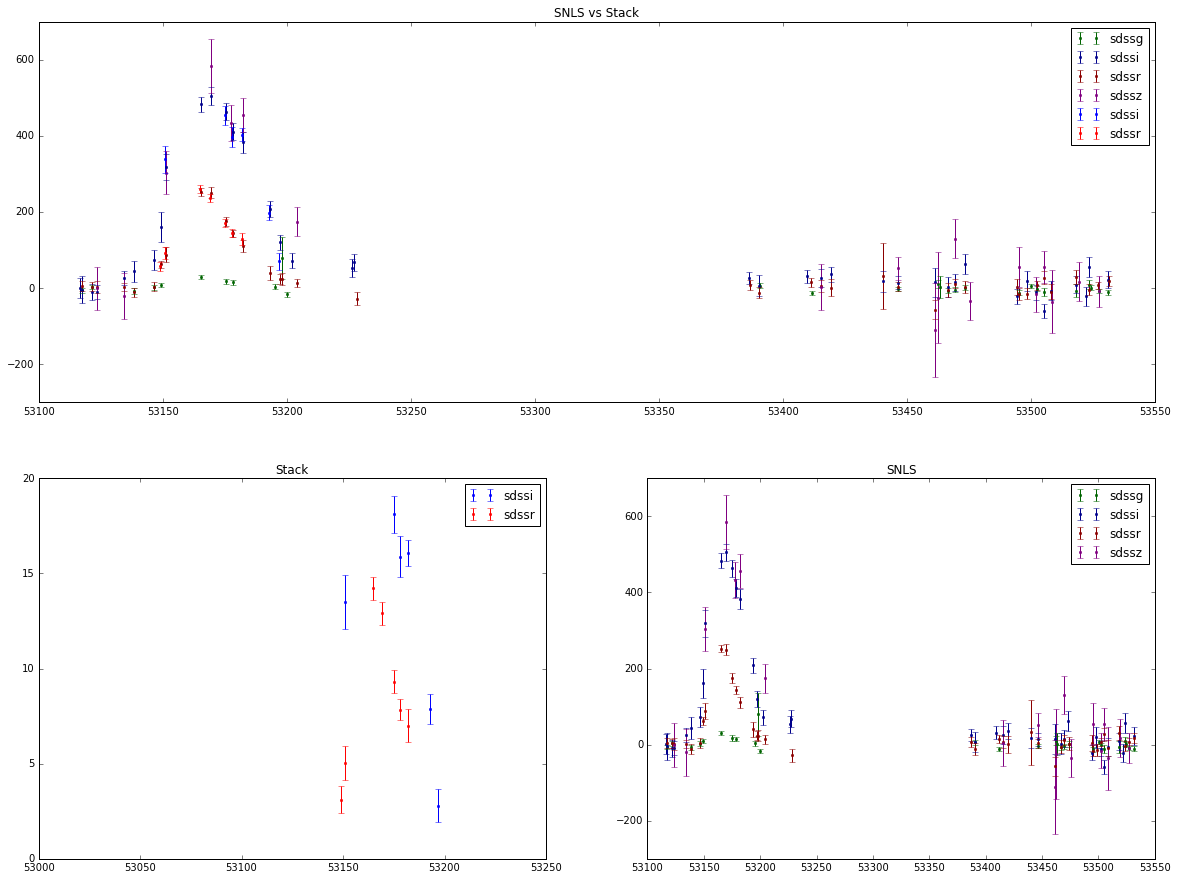

214.857416746 53.1636587584
{'sdssi': nan, 'sdssr': 21.686919689431978, 'sdssz': nan, 'sdssg': 18.073922596555253}


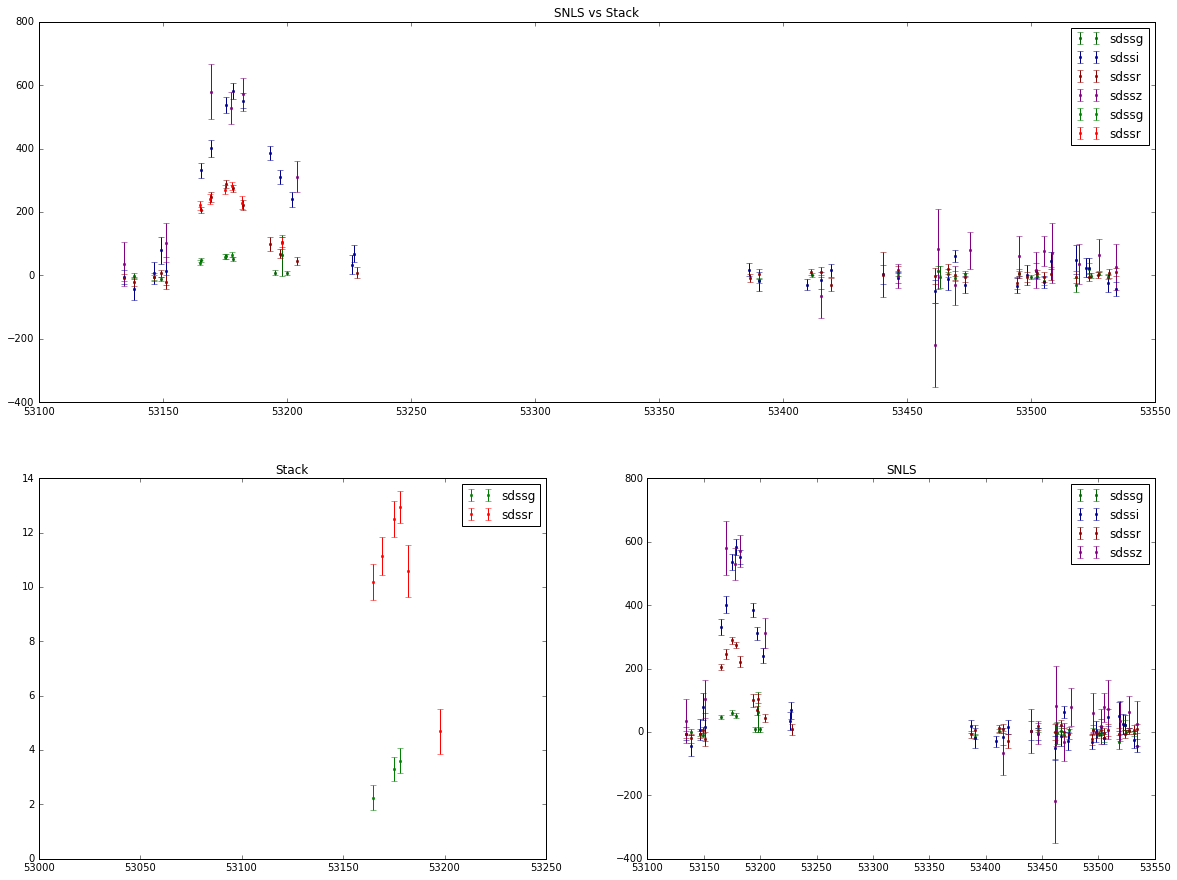

214.162831836 53.0932170458
{'sdssi': 29.327378974169893, 'sdssr': 18.460536533404262, 'sdssz': nan, 'sdssg': nan}


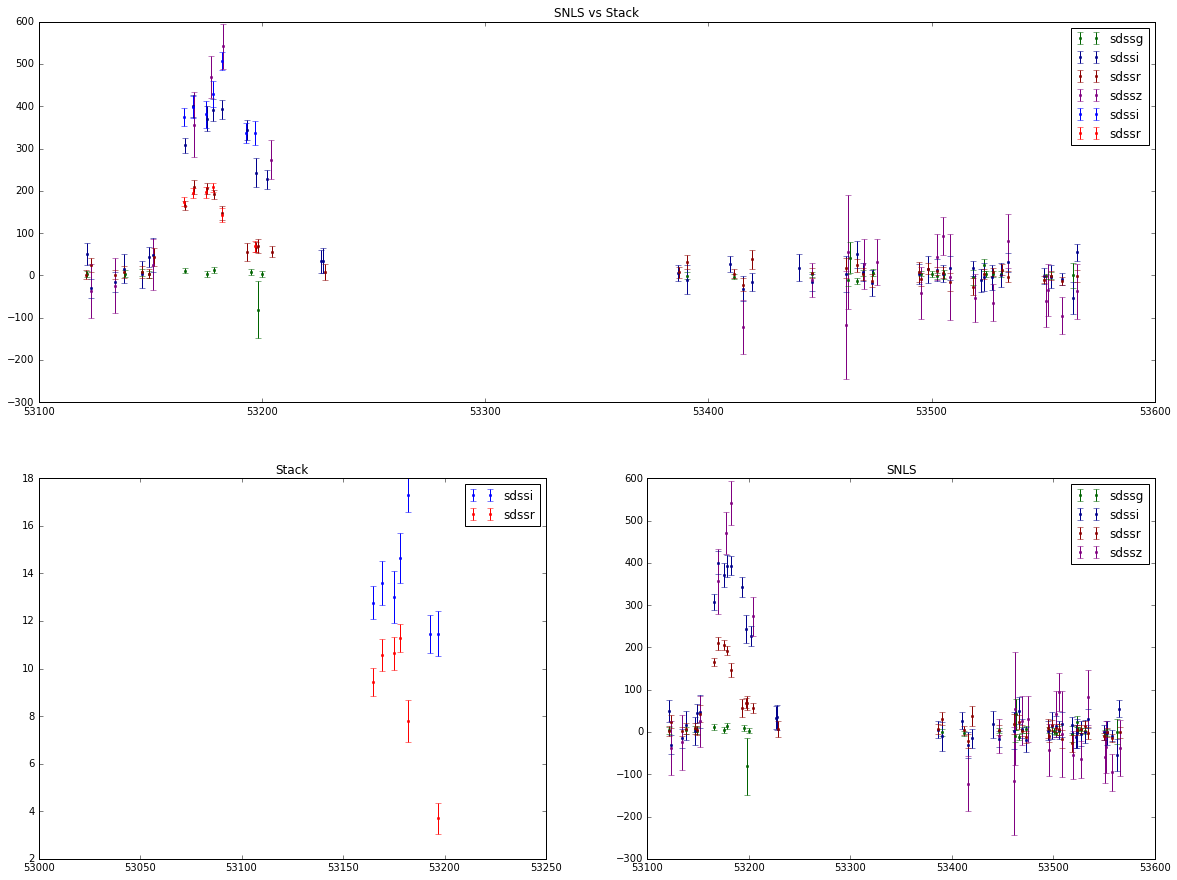

214.162831646 53.0932168287
{'sdssi': 29.232203162629105, 'sdssr': 18.427656356777629, 'sdssz': nan, 'sdssg': nan}


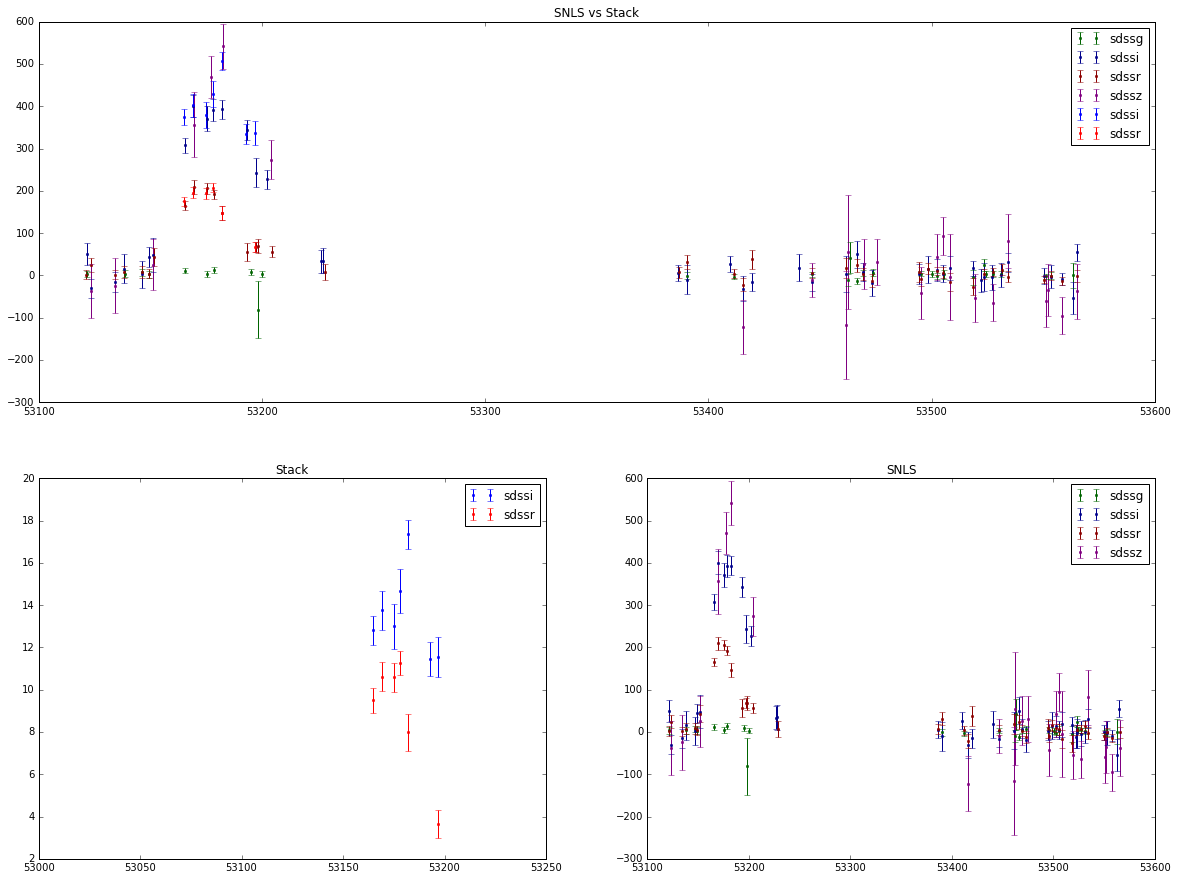

214.075822312 52.273858511
{'sdssi': 23.032568244648644, 'sdssr': 19.760235680500255, 'sdssz': nan, 'sdssg': nan}


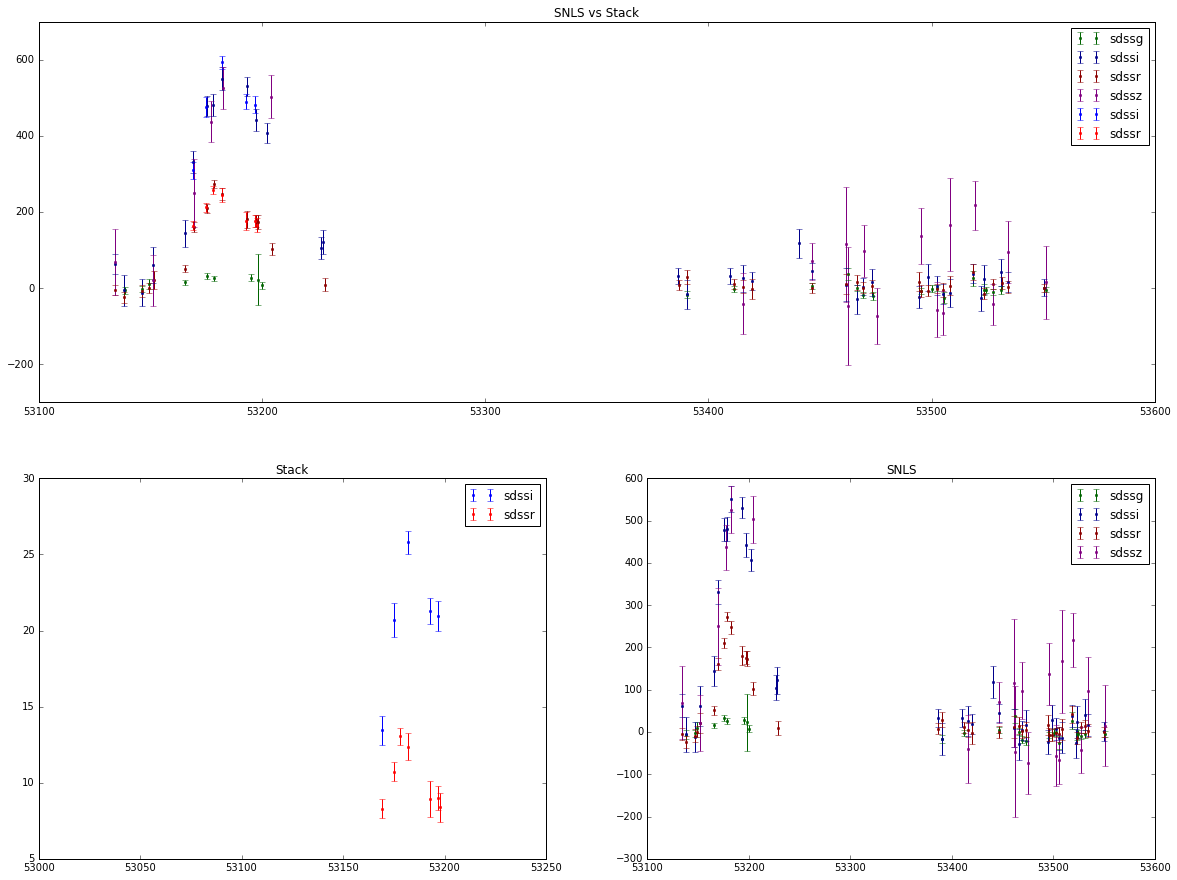

214.07582238 52.2738585324
{'sdssi': 23.162637956334919, 'sdssr': 19.762227978612174, 'sdssz': nan, 'sdssg': nan}


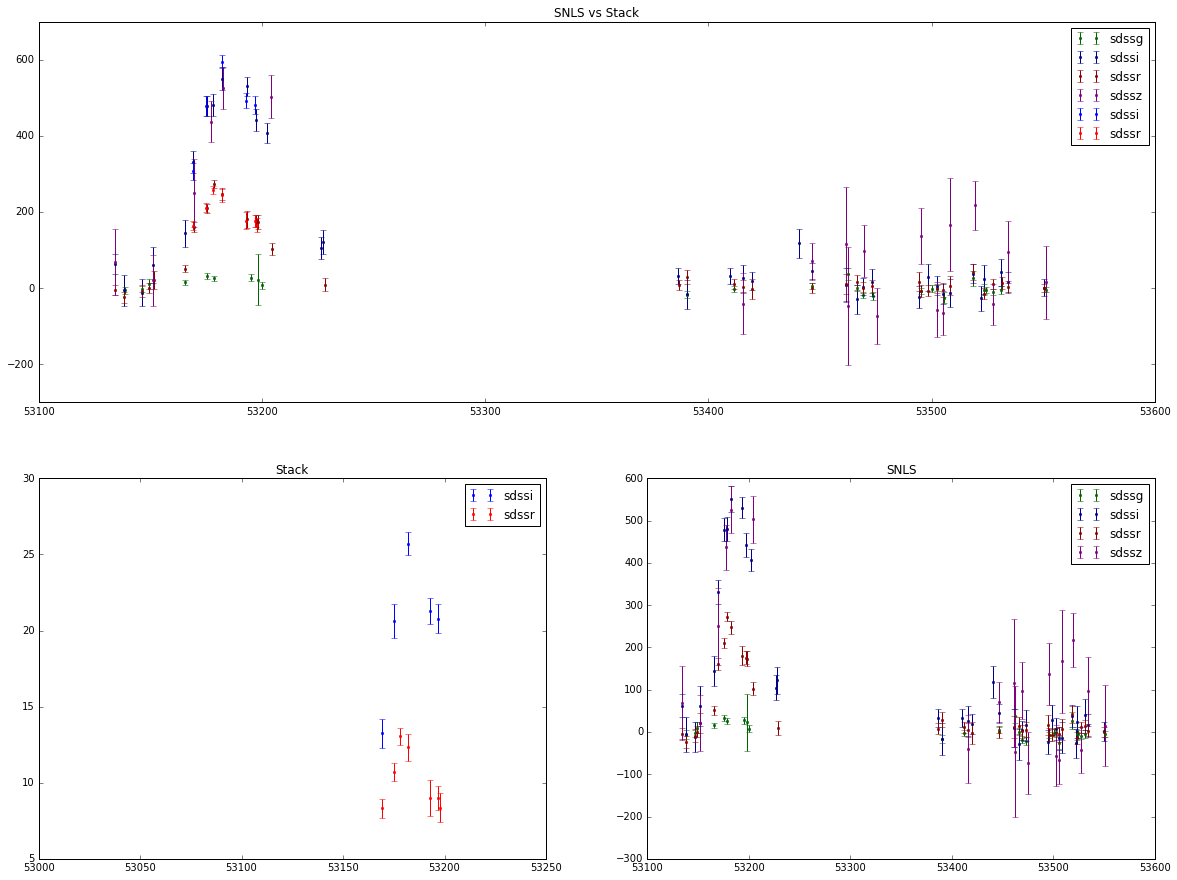

214.075822089 52.2738645502
{'sdssi': 21.761618461028181, 'sdssr': 20.068583374245193, 'sdssz': nan, 'sdssg': nan}


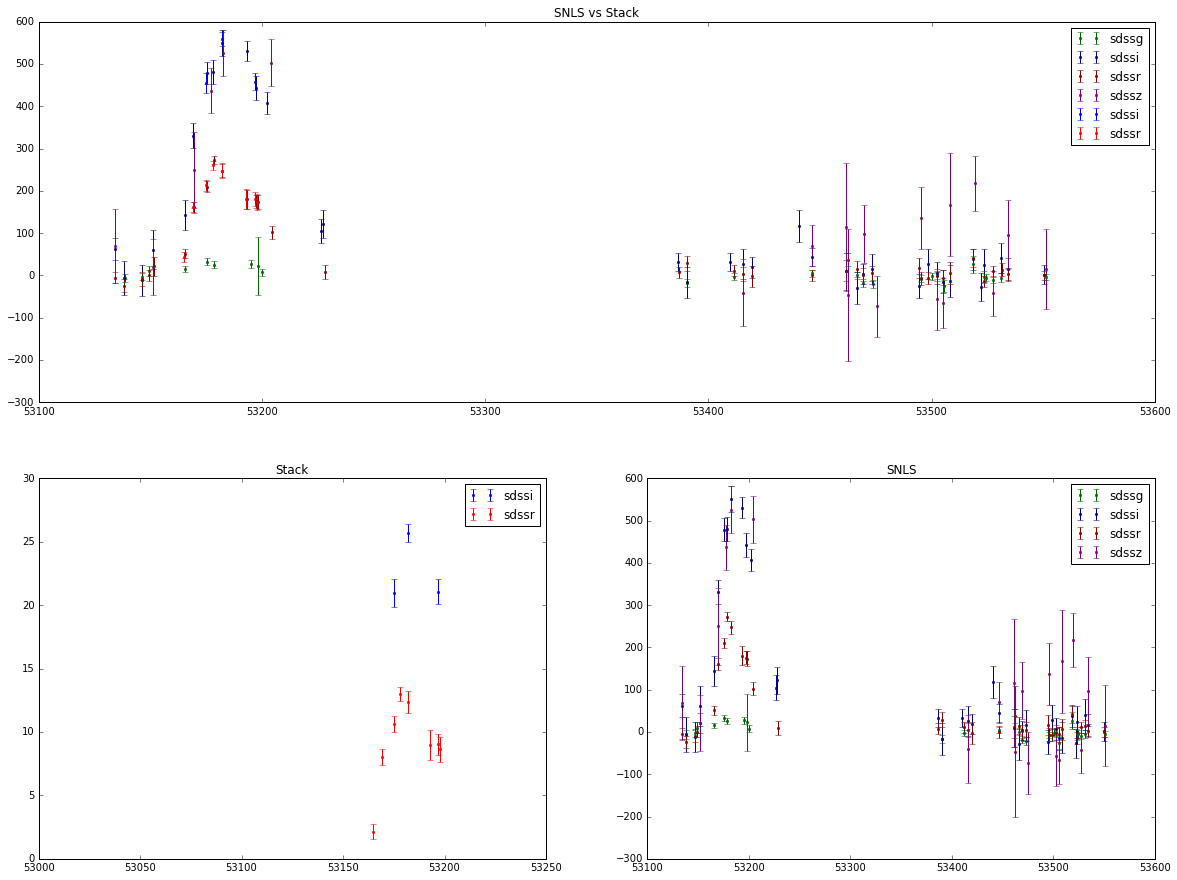

214.075822092 52.273858585
{'sdssi': 22.973071774873443, 'sdssr': 20.211952130172758, 'sdssz': nan, 'sdssg': nan}


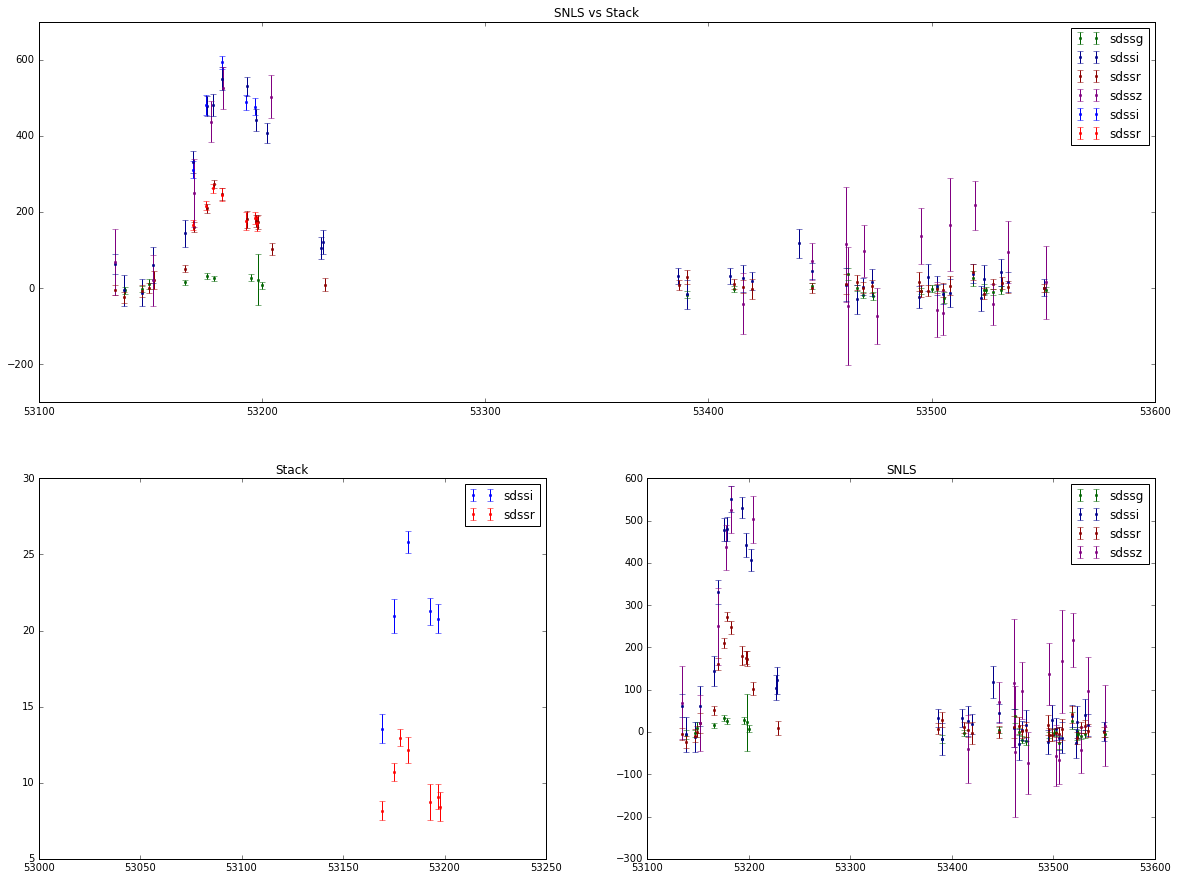

215.61118118 52.3335043983
{'sdssi': 24.178305638873216, 'sdssr': 19.400735694110264, 'sdssz': nan, 'sdssg': 16.058143628493593}


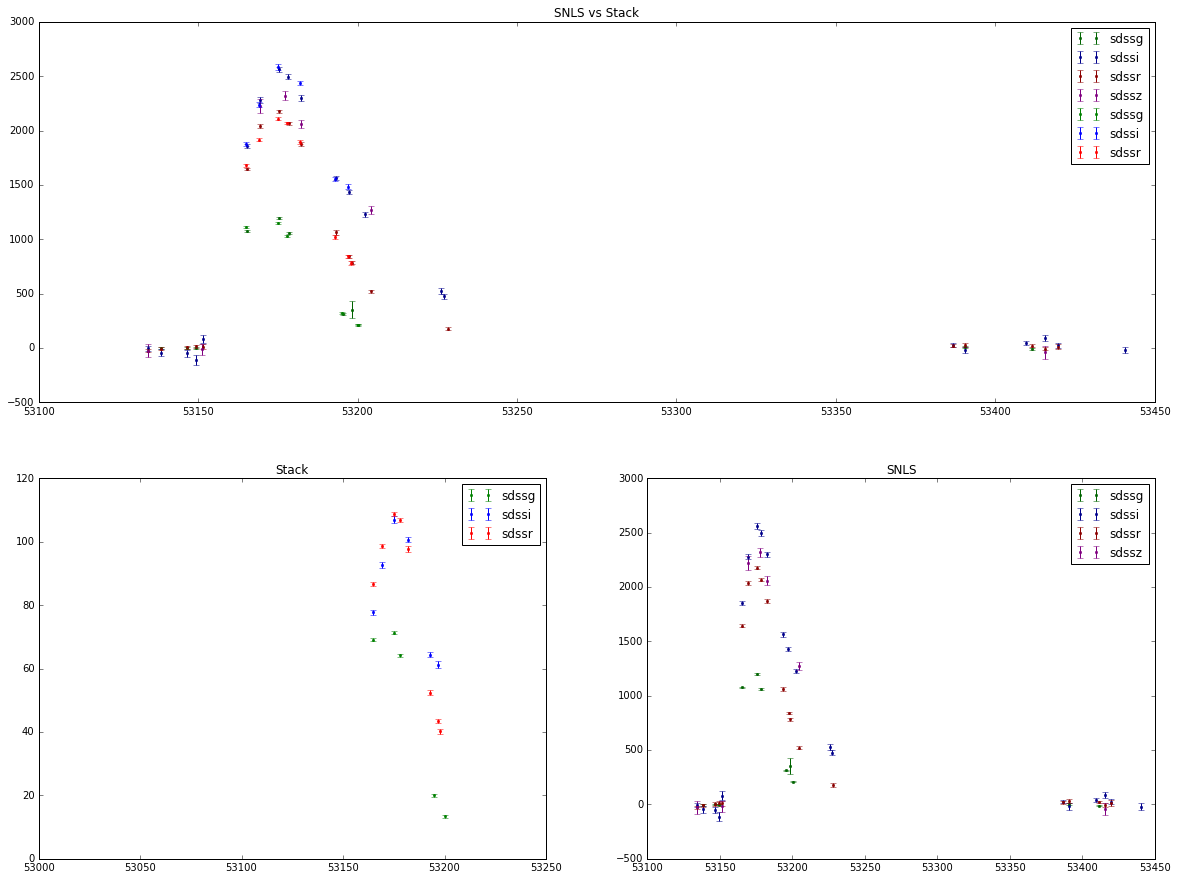

215.079852329 53.1543395668
{'sdssi': 23.784344129271002, 'sdssr': 19.801566925611066, 'sdssz': nan, 'sdssg': nan}


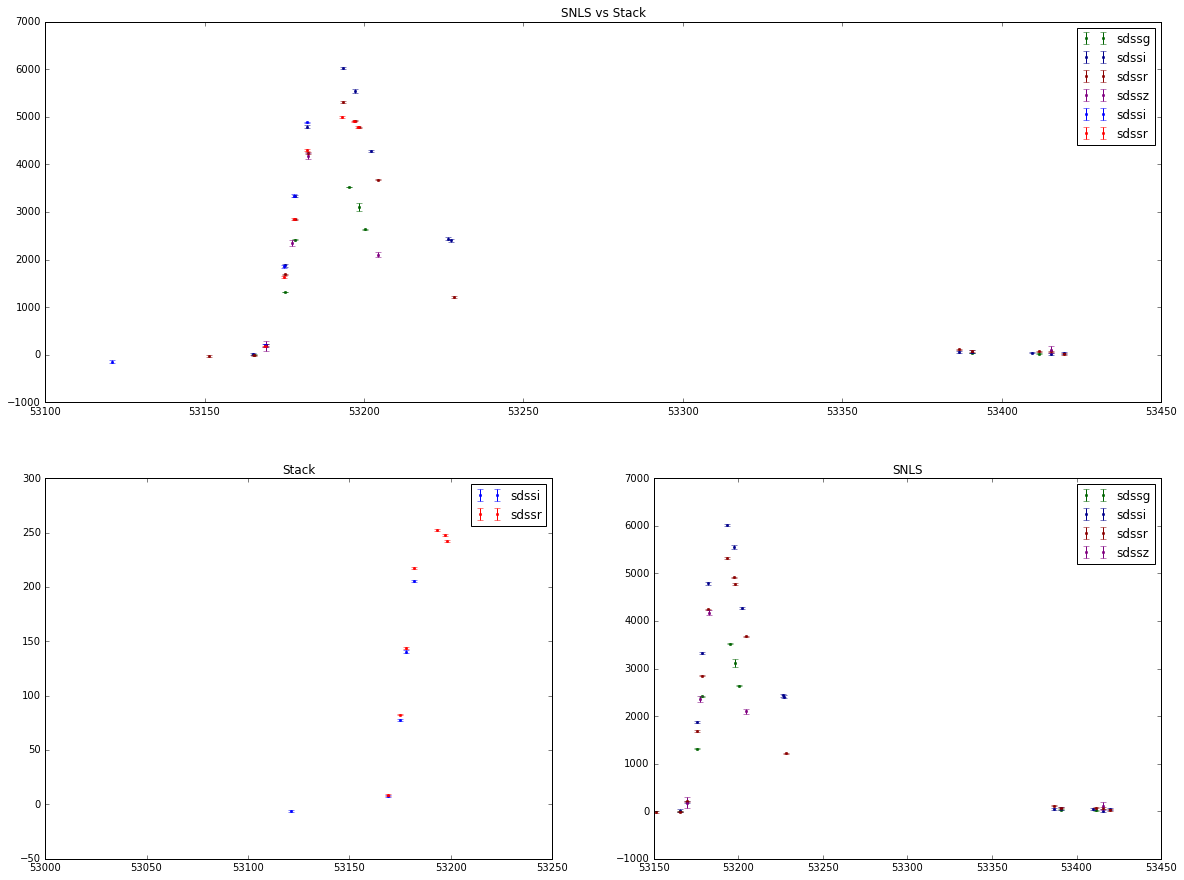

215.660304704 52.6487403403
{'sdssi': 26.715079126833384, 'sdssr': 19.025538042408364, 'sdssz': nan, 'sdssg': nan}


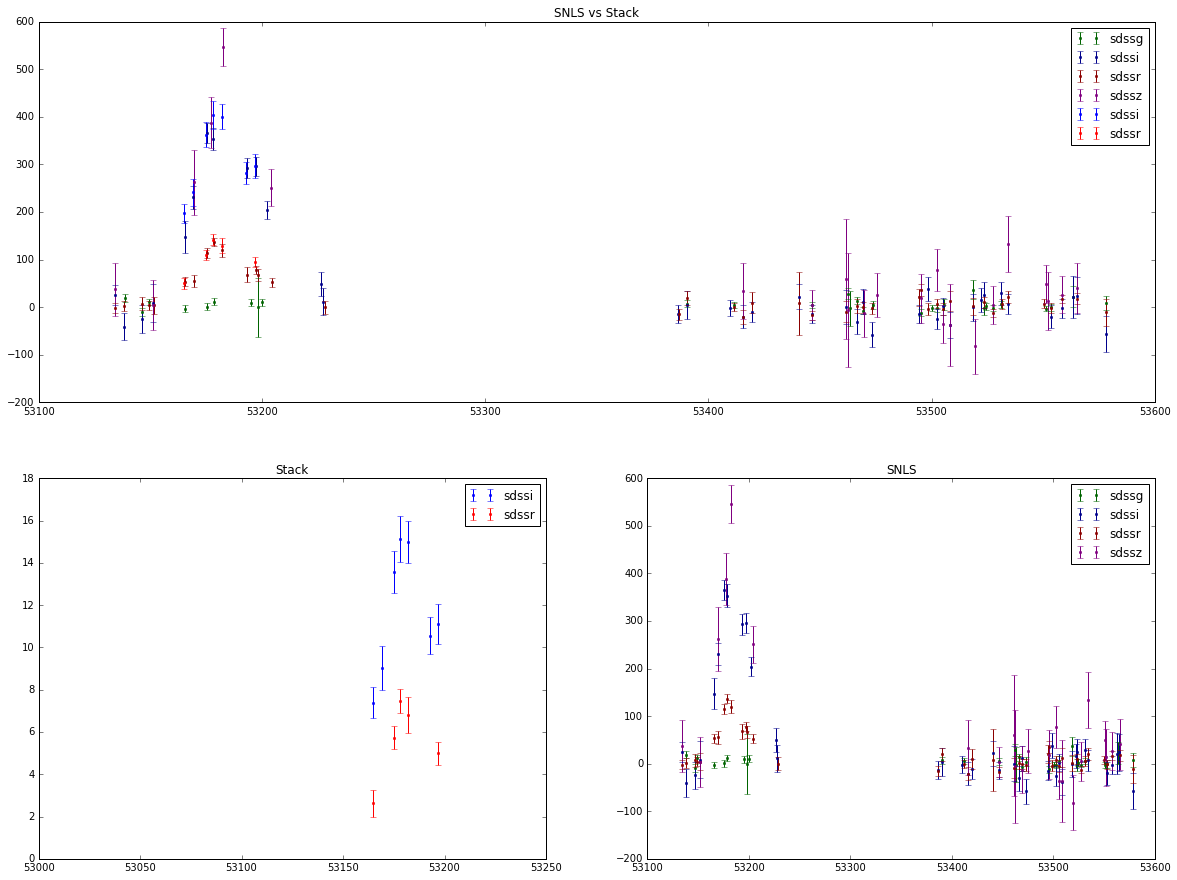

214.734589017 52.1874602893
{'sdssi': 25.569611496221974, 'sdssr': 18.647877730153791, 'sdssz': nan, 'sdssg': nan}


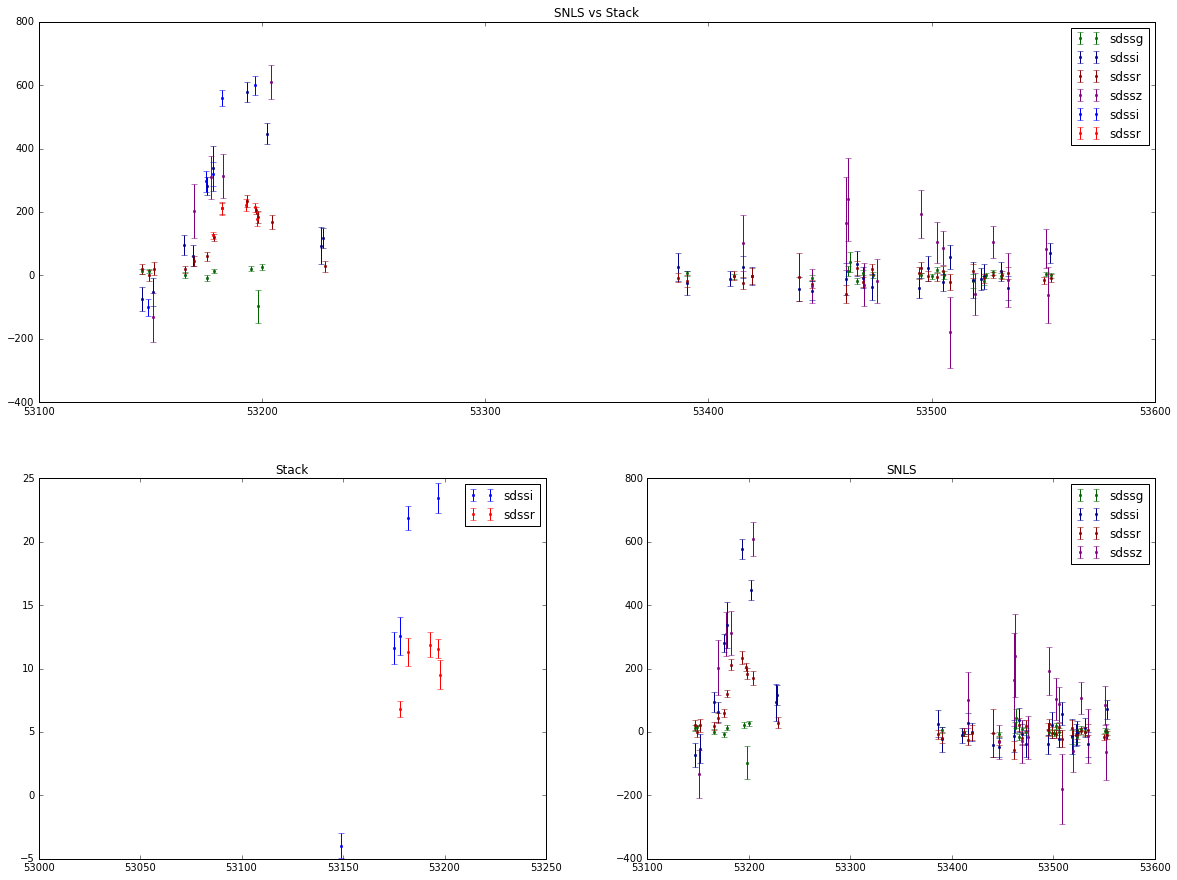

214.913999465 52.5538902212
{'sdssi': 25.465233974479805, 'sdssr': 19.762408141936984, 'sdssz': nan, 'sdssg': nan}


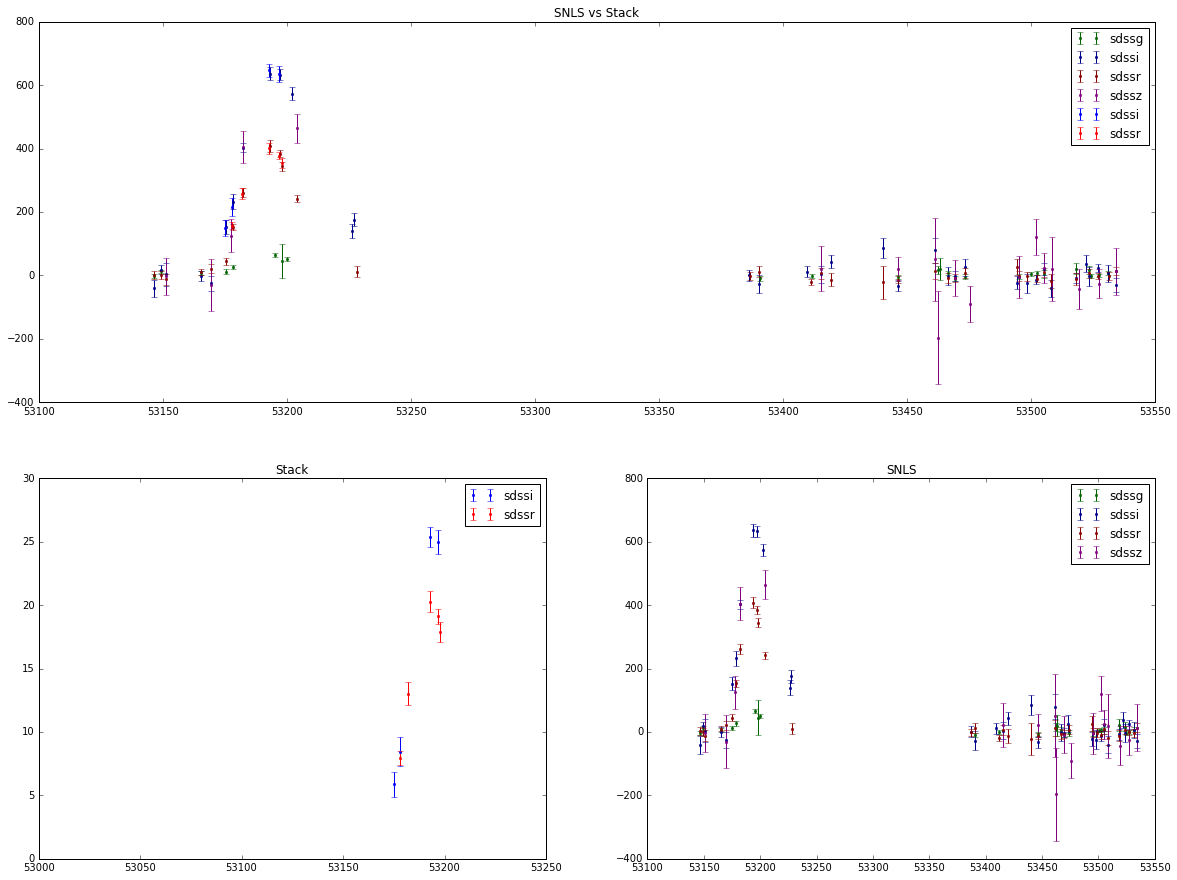

214.913973635 52.5538986835
{'sdssi': 26.504384129677323, 'sdssr': 19.783233563952592, 'sdssz': nan, 'sdssg': nan}


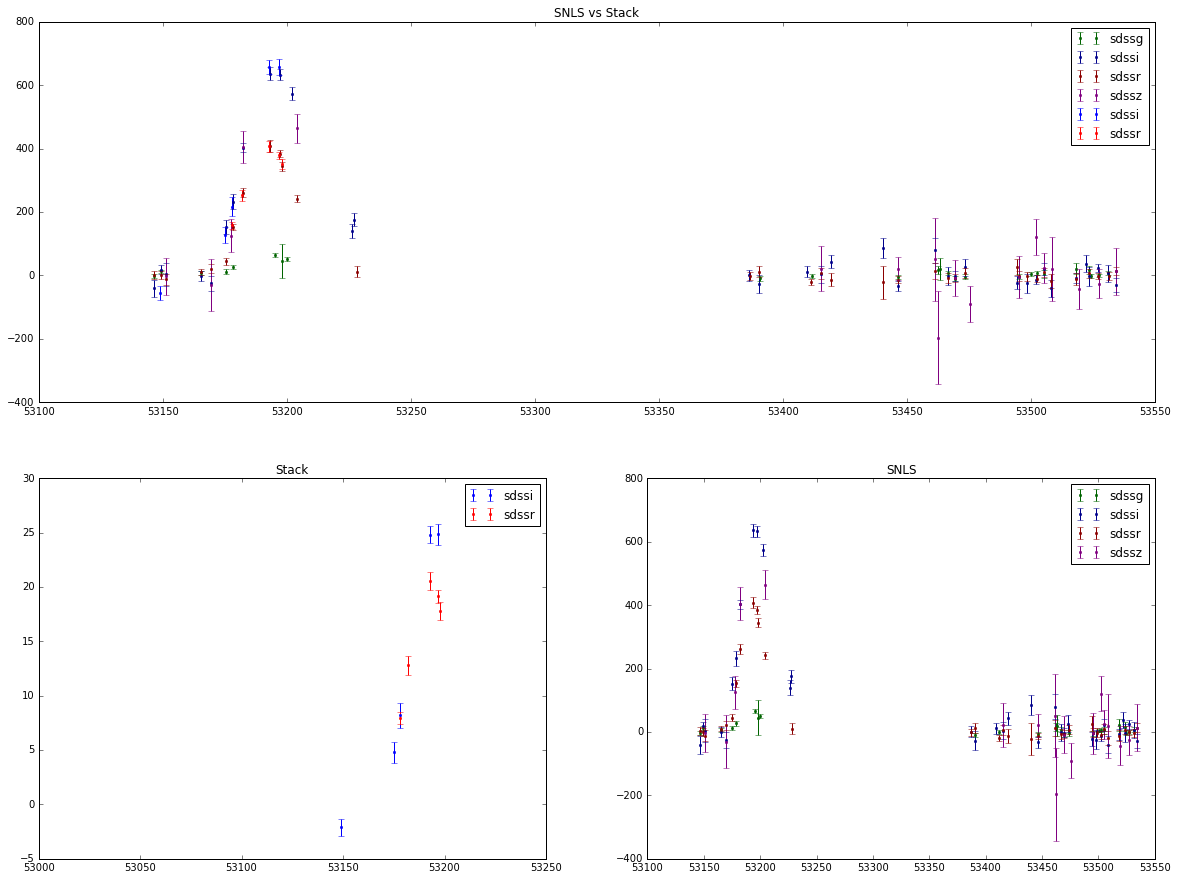

In [58]:
coords = []
for match in matches_45:
    t = match[-1]
    

    plt.figure(figsize=(20,15))
    c = coord.SkyCoord(ra=float(np.mean(t['ra'])), dec=float(np.mean(t['dec'])), unit=(u.rad))
    print c.ra.deg, c.dec.deg
    coords.append(c)
    plt.subplot2grid((2, 2), (0, 0), colspan=2)
    
    n_factors = {}
    n_factors["sdssi"]=normalize_light_curve( match[0],t, "sdssi")
    n_factors["sdssg"]=normalize_light_curve( match[0],t, "sdssg")
    n_factors["sdssr"]=normalize_light_curve( match[0],t, "sdssr")
    n_factors["sdssz"]=normalize_light_curve( match[0],t, "sdssz")
    
    print n_factors
    
    plt.title("SNLS vs Stack")
    show_multi_filter_light_curve(match[0], snls_colors)
    show_multi_filter_light_curve(t, stack_colors, n_factors)
    
    plt.subplot2grid((2, 2), (1, 0))
    plt.title("Stack")
    plt.xlim(xmin=53000, xmax=53250)
    show_multi_filter_light_curve(t, stack_colors)
    
    plt.subplot2grid((2, 2), (1, 1))
    plt.title("SNLS")
    show_multi_filter_light_curve(match[0], snls_colors)

    plt.show()
    
   
    #t_by_filter = t.group_by("bandpass")

    #indices = t_by_filter.groups.indices
    #print indices

    #for i in range(0, len(indices)-1):

    #    data = t_by_filter[indices[i]:indices[i+1]]
        #print data
    #    plt.errorbar(data["mjd"], data["flux"],yerr=data["flux_error"], fmt='.', markersize='5')
        
    #plt.show()
    #print "done"

In [51]:
for i, c in enumerate(coords):
    print i, c

0 <SkyCoord (ICRS): (ra, dec) in deg
    ( 214.43765177,  52.46775242)>
1 <SkyCoord (ICRS): (ra, dec) in deg
    ( 214.45830128,  52.963539)>
2 <SkyCoord (ICRS): (ra, dec) in deg
    ( 215.09975834,  52.82088091)>
3 <SkyCoord (ICRS): (ra, dec) in deg
    ( 215.09952026,  52.82070657)>
4 <SkyCoord (ICRS): (ra, dec) in deg
    ( 214.55176414,  52.65839123)>
5 <SkyCoord (ICRS): (ra, dec) in deg
    ( 214.45160556,  52.47067178)>
6 <SkyCoord (ICRS): (ra, dec) in deg
    ( 214.54157176,  52.27769607)>
7 <SkyCoord (ICRS): (ra, dec) in deg
    ( 214.54157124,  52.27769563)>
8 <SkyCoord (ICRS): (ra, dec) in deg
    ( 214.44190037,  52.26757133)>
9 <SkyCoord (ICRS): (ra, dec) in deg
    ( 214.78273848,  53.07192297)>
10 <SkyCoord (ICRS): (ra, dec) in deg
    ( 214.60898784,  52.52863965)>
11 <SkyCoord (ICRS): (ra, dec) in deg
    ( 214.60897585,  52.52847787)>
12 <SkyCoord (ICRS): (ra, dec) in deg
    ( 214.24110417,  52.37951886)>
13 <SkyCoord (ICRS): (ra, dec) in deg
    ( 214.24111011,  52.3

In [56]:
s1 = {'ra':coords[27].ra.rad, 'dec':coords[27].dec.rad}
s2 = {'ra':coords[30].ra.rad, 'dec':coords[30].dec.rad}

DSTools.source_distance(s1, s2)

0.00083520788136296539

In [19]:
def show_matches_2(matches):
    factors = []
    for match in matches:
        print len(match[-1])
        print np.rad2deg(match[0][0]['ra']), np.rad2deg(match[0][0]['dec'])
        lc_fluxes = match[0]["flux"]
        factor = max(match[-1]['flux']) / max(lc_fluxes)
        lc_fluxes = np.multiply(lc_fluxes, factor)
        lc_errors = np.multiply(match[0]["flux_error"], factor)
        
        factors.append(factor)
        plt.figure(figsize=(20,10))
        print match[-1]["flux"]
        plt.errorbar(match[-1]["mjd"], match[-1]["flux"],yerr=match[-1]["flux_error"], fmt='.', markersize='5')
        plt.errorbar(match[0]["mjd"], lc_fluxes, yerr=lc_errors, fmt='.', markersize='5')
        plt.show()

In [34]:
def FluxToMagnitud( flux,  zp):
    return zp-(2.5*np.log10(flux))

def FluxErrorToMagnitud(flux, error):
    return (2.5/np.log(10))*(error/flux)

In [54]:
writable_lcs[0]

mjd,classification,zpsys,flux,ra,flux_error,dec,zp,bandpass
int64,float64,str2,float64,object,float64,object,float64,str5
53801,4.0,ab,nan,3.73815252037,inf,0.920359071892,30.0,sdssi
53910,4.0,ab,nan,3.73815426396,inf,0.920363046934,30.0,sdssi
53919,4.0,ab,nan,3.73815464166,inf,0.920362931508,30.0,sdssi
53939,4.0,ab,nan,3.7381547755,inf,0.920363288688,30.0,sdssi
53766,4.0,ab,nan,3.73815967247,inf,0.92036664143,30.0,sdssi
53772,4.0,ab,nan,3.73815682707,inf,0.920362636196,30.0,sdssi
53855,4.0,ab,6.59291887283,3.73815972555,0.903293907642,0.920368219195,30.0,sdssi
53879,4.0,ab,nan,3.73815986103,inf,0.920366604737,30.0,sdssi
53892,4.0,ab,nan,3.73815303625,inf,0.920366628287,30.0,sdssi


In [31]:
writable_lcs = []
for lc in tot_lcs:
    t_by_filter = lc.group_by("bandpass")

    indices = t_by_filter.groups.indices
    
    if len(indices) > 2:
        writable_lcs.append(lc)

In [53]:
len(writable_lcs)

19346

In [44]:
lc['ra'].astype(float)

3.75556378927
3.75556291445
3.75556345397
3.75555760783


In [54]:
for i, lc in enumerate(tot_lcs):
    l = lc.copy()
    ms = []
    m_es = []
    lc['ra'] = lc['ra'].astype(float)
    lc['dec'] = lc['dec'].astype(float)
    for row in lc:
        
        row['zp'] = 30.0
        
print tot_lcs

[<Table length=4>
  mjd   classification zpsys      flux      ...      dec          zp   bandpass
float64    float64      str2    float64     ...    float64     float64   str5  
------- -------------- ----- -------------- ... -------------- ------- --------
53081.0            4.0    ab -4.36701488495 ... 0.915068703415    30.0    sdssr
53083.0            4.0    ab -4.39094591141 ... 0.915068736697    30.0    sdssr
53094.0            4.0    ab -4.38691329956 ... 0.915068767411    30.0    sdssr
53109.0            4.0    ab -4.34102487564 ... 0.915069517312    30.0    sdssr, <Table length=4>
  mjd   classification zpsys      flux      ...      dec          zp   bandpass
float64    float64      str2    float64     ...    float64     float64   str5  
------- -------------- ----- -------------- ... -------------- ------- --------
53081.0            4.0    ab -6.87165164948 ... 0.915070534664    30.0    sdssr
53083.0            4.0    ab -6.88749361038 ... 0.915070553938    30.0    sdssr
5309

In [55]:
tot_lcs[0]

mjd,classification,zpsys,flux,ra,flux_error,dec,zp,bandpass
float64,float64,str2,float64,float64,float64,float64,float64,str5
53081.0,4.0,ab,-4.36701488495,3.7566809512,0.567446768284,0.915068703415,30.0,sdssr
53083.0,4.0,ab,-4.39094591141,3.75668095154,0.567171871662,0.915068736697,30.0,sdssr
53094.0,4.0,ab,-4.38691329956,3.75668093605,0.587322711945,0.915068767411,30.0,sdssr
53109.0,4.0,ab,-4.34102487564,3.75668089489,0.572784423828,0.915069517312,30.0,sdssr


In [60]:
from astropy.table import Column

from astropy.io import ascii

for i, lc in enumerate(writable_lcs):
    l = lc.copy()
    ms = []
    m_es = []
    for row in lc:
        row['ra'] = float(row['ra'])
        row['dec'] = float(row['dec'])
        row['zp'] = 30.0
        
        if np.isnan(row['flux']) == False and row['flux'] > 0: 
            f =  FluxToMagnitud(row['flux'], row['zp'])
            e = FluxErrorToMagnitud(row['flux'],row['flux_error'])
            ms.append(f)
            m_es.append(e)
        else:
            ms.append(np.nan)
            m_es.append(np.nan)
    c_ms = Column(ms, name='magnitude')
    c_m_es = Column(m_es, name='magnitude_error')
    l.add_column(c_ms)
    l.add_column(c_m_es)
        
    #ascii.write(l, '/renoir_data_02/jpreyes/lsst_data/light_curves/multicolour_set/'+str(i)+'.dat')

In [4]:
date_catalog = butler.get("dayDiff_class_diaSrc", dataId={"filter":'r',"tract":0, "patch":'20,20', 'date':'2006-06-02'})
dayDiff =  butler.get("dayDiff_differenceExp", dataId={"filter":'r',"tract":0, "patch":'20,20', 'date':'2006-06-02'})
ds9.mtv(dayDiff.getMaskedImage().getImage(), frame=2)

for source in date_catalog:
    #wcs = dayDiff.getWcs()
    #angle_ra = afwGeom.Angle(source["coord_ra"], afwGeom.rad)
    #angle_dec = afwGeom.Angle( source["coord_dec"] , afwGeom.rad)
    #coord = wcs.skyToPixel(angle_ra, angle_dec)
    ds9.dot("o", source.getX(), source.getY(), size = 25, ctype = ds9.RED, frame=2)

In [5]:
dayCoadd =  butler.get("dayCoadd", dataId={"filter":'r',"tract":0, "patch":'20,20', 'date':'2006-06-02'})
ds9.mtv(dayCoadd.getMaskedImage().getImage(), frame=4)

In [6]:
def visualize(patch, date, ra, dec, exp, frame=1):
    
    dataId= {"filter":filter,"tract":0, "patch":patch, 'date':date}
    dayDiff = butler.get(exp, dataId=dataId)
    catalog = butler.get("dayDiff_class_diaSrc", dataId=dataId)
    ds9.mtv(dayDiff, frame=frame)
    ds9.setMaskTransparency(100, frame=frame)
    for source in catalog:

        ds9.dot("o", source.getX(), source.getY(), size = 25, ctype = ds9.RED, frame=frame)

    bbox = dayDiff.getBBox()
    wcs = dayDiff.getWcs()

    angle_ra = afwGeom.Angle(ra, afwGeom.degrees)
    angle_dec = afwGeom.Angle( dec , afwGeom.degrees)
    coord = wcs.skyToPixel(angle_ra, angle_dec)
    print coord
    ds9.dot("o", coord.getX(), coord.getY(), size = 20, ctype = ds9.BLUE, frame=frame)

In [10]:
pa = '10,5'
ra = 215.18155833333333
dec = 52.191063888888884
filter='r'
#exp = "dayCoadd"
exp = "dayDiff_differenceExp"

visualize(pa, '2006-02-03', ra , dec , exp, frame = 1)

(10860, 5356.5)


In [11]:
pa = '10,5'
ra = 215.18155833333333
dec = 52.191063888888884
filter='r'
exp = "dayCoadd"
#exp = "dayDiff_differenceExp"

visualize(pa, '2006-02-03', ra , dec , exp, frame = 3)

(10860, 5356.5)


In [59]:
date = dates[0]
patch_and_coord = []
degrees = []
for lc in snls_array:
    for patch in patches:

        if butler.datasetExists("dayDiff_differenceExp", dataId={"filter":'r',"tract":0, "patch":patch, 'date':date}):
                dayDiff = butler.get("dayDiff_differenceExp", dataId={"filter":'r',"tract":0, "patch":patch, 'date':date})
                bbox = dayDiff.getBBox()
                wcs = dayDiff.getWcs()
                
                angle_ra = afwGeom.Angle(lc[0]["ra"])
                angle_dec = afwGeom.Angle(lc[0]["dec"])
                coord = wcs.skyToPixel(angle_ra, angle_dec)
                
                if bbox.contains(afwGeom.Point2I(coord)):
                    patch_and_coord.append((patch, angle_ra.asDegrees(), angle_dec.asDegrees(), np.median(lc['mjd'])))
                    #break
                    
    degrees.append(coord)

In [60]:
patch_and_coord

[('19,10', 214.43777916666664, 52.46779166666667, 53149.32),
 ('19,20', 214.45824583333328, 52.96361111111111, 53167.380000000005),
 ('11,17', 215.0996583333333, 52.820933333333336, 53182.339999999997),
 ('18,14', 214.5518083333333, 52.65833055555555, 53165.410000000003),
 ('19,10', 214.4516875, 52.47067777777778, 53202.290000000001),
 ('18,6', 214.5416708333333, 52.27768611111111, 53151.449999999997),
 ('18,7', 214.5416708333333, 52.27768611111111, 53151.449999999997),
 ('19,6', 214.44200833333332, 52.26755277777778, 53165.400000000001),
 ('15,22', 214.78264166666665, 53.07194722222223, 53149.32),
 ('17,11', 214.60909999999998, 52.52846666666667, 53165.354999999996),
 ('17,12', 214.60909999999998, 52.52846666666667, 53165.354999999996),
 ('21,8', 214.2411875, 52.379472222222226, 53176.379999999997),
 ('21,9', 214.2411875, 52.379472222222226, 53176.379999999997),
 ('22,8', 214.2411875, 52.379472222222226, 53176.379999999997),
 ('22,9', 214.2411875, 52.379472222222226, 53176.37999999999

In [5]:
def visualize(patch, date, ra, dec, exp, frame=1):
    
    dataId= {"filter":filter,"tract":0, "patch":patch, 'date':date}
    dayDiff = butler.get(exp, dataId=dataId)
    catalog = butler.get("dayDiff_class_diaSrc", dataId=dataId)
    ds9.mtv(dayDiff, frame=frame)
    ds9.setMaskTransparency(100, frame=frame)
    for source in catalog:

        ds9.dot("o", source.getX(), source.getY(), size = 25, ctype = ds9.RED, frame=frame)

    bbox = dayDiff.getBBox()
    wcs = dayDiff.getWcs()

    angle_ra = afwGeom.Angle(ra, afwGeom.degrees)
    angle_dec = afwGeom.Angle( dec , afwGeom.degrees)
    coord = wcs.skyToPixel(angle_ra, angle_dec)
    print coord
    ds9.dot("o", coord.getX(), coord.getY(), size = 20, ctype = ds9.BLUE, frame=frame)

In [7]:
pa = '15,15'
ra = 215.18155833333333
dec = 52.191063888888884
filter='r'
#exp = "dayCoadd"
exp = "dayDiff_differenceExp"

visualize(pa, '2006-02-06', ra , dec , exp, frame = 4)

(10860, 5356.5)


In [60]:
dates

['2004-03-17',
 '2004-03-19',
 '2004-03-30',
 '2004-04-14',
 '2004-04-17',
 '2004-04-21',
 '2004-04-22',
 '2004-04-26',
 '2004-04-28',
 '2004-05-09',
 '2004-05-13',
 '2004-05-21',
 '2004-05-24',
 '2004-05-26',
 '2004-06-09',
 '2004-06-13',
 '2004-06-19',
 '2004-06-21',
 '2004-06-22',
 '2004-06-26',
 '2004-07-07',
 '2004-07-09',
 '2004-07-11',
 '2004-07-12',
 '2004-07-14']

In [12]:
dataId= {"filter":filter,"tract":0, "patch":'23,7', 'date':dates[0]}
dayDiff = butler.get(exp, dataId=dataId)
print dayDiff.getBBox()

dataId= {"filter":filter,"tract":0, "patch":'24,7', 'date':dates[0]}
dayDiff = butler.get(exp, dataId=dataId)
print dayDiff.getBBox()

(minimum=(22900, 6900), maximum=(24099, 8099))
(minimum=(23900, 6900), maximum=(25099, 8099))


In [14]:
t = res[1][0]

In [50]:
tot_lcs[0]['ra'].astype(float)

3.7566809512
3.75668095154
3.75668093605
3.75668089489


In [83]:
dataId= {"filter":filter,"tract":0, "patch":'10,10', 'date':'2008-02-12'}
cat = butler.get("dayDiff_class_diaSrc", dataId=dataId)
dayDiff = butler.get("dayDiff_differenceExp", dataId=dataId)

In [88]:
for c in cat:
    print c["classification_dipole"]

3.0
7.0
3.0
3.0
3.0
7.0
7.0
7.0
0.0
0.0
3.0
0.0
7.0
7.0
3.0
0.0
0.0
0.0
7.0
7.0


In [89]:
reload(DSTools)
for i, c in enumerate(cat):
    stamp = DSTools.get_stamp(c, dayDiff, offset=10)
    ds9.mtv(stamp, frame=i+1)

10623 10001
(10614, 9992) (10633, 10011)
9900 9900
Box2I(Point(704,82),Extent(40,40))
Box2I(Point(9900,9900),Extent(1200,1200))


LengthError: 
  File "src/image/Image.cc", line 80, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::afw::geom::Extent2I = lsst::afw::geom::Extent<int, 2>]
    Box2I(Point2I(-9196,-9818),Extent2I(40,40)) doesn't fit in image 1200x1200 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(-9196,-9818),Extent2I(40,40)) doesn't fit in image 1200x1200'


In [80]:
ds9.mtv(stamp)

In [86]:
c.schema

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['F'](name="classification_dipole", doc="probability of being a dipole"), Key<F>(offset=32, nElements=1)),
    (Field['Flag'](name="ip_diffim_NaiveDipoleCentroid_flag", doc="general failure flag, set if anything went wrong"), Key['Flag'](offset=40, bit=0)),
    (Field['Flag'](name="ip_diffim_NaiveDipoleCentroid_pos_flag", doc="failure flag for positive, set if anything went wrong"), Key['Flag'](offset=40, bit=1)),
    (Field['Flag'](name="ip_diffim_NaiveDipoleCentroid_neg_flag", doc="failure flag for negative, set if anything went wrong"), Key['Flag'](offset=40, bit=2)),
    (Field['D'](name="ip_d

In [ ]:
dayDiff.wri